In [1]:
# import tensorflow as tf
# from tensorflow.keras import layers

# print('tensorflow version: {}'.format(tf.__version__))
# print('GPU 사용 가능 여부: {}'.format(tf.test.is_gpu_available()))

tensorflow version: 2.3.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU 사용 가능 여부: False


In [ ]:
# def normalization(df, columns, mode='z'):
#     if mode == 'm' :
#         for colname in columns:
#             df[colname] = (df[colname] - df[colname].min())/(df[colname].max()-df[colname].min())
#         return df
#     if mode == 'z' :
#         for colname in columns:
#             df[colname] = (df[colname] - df[colname].mean())/df[colname].std()
#         return df

# 데이터 업로드

In [260]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib import cm
import os as os
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import lightgbm as lgb
import scipy as sp
from scipy.special import boxcox1p
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from scipy.stats import uniform
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
# 기본 설정 읽기
import matplotlib.pyplot as plt

# size, family
print('# 설정되어있는 폰트 사이즈')
print (plt.rcParams['font.size'] ) 
print('# 설정되어있는 폰트 글꼴')
print (plt.rcParams['font.family'] )

# 설정되어있는 폰트 사이즈
10.0
# 설정되어있는 폰트 글꼴
['sans-serif']


In [3]:
import platform
platform.system()

'Windows'

In [4]:
# 운영체제별 한글 폰트 설정
if platform.system() == 'Darwin': # Mac 환경 폰트 설정
    plt.rc('font', family='AppleGothic')
elif platform.system() == 'Windows': # Windows 환경 폰트 설정
    plt.rc('font', family='Malgun Gothic')

plt.rc('axes', unicode_minus=False) # 마이너스 폰트 설정

In [5]:
pwd

'C:\\Users\\82109\\Desktop\\Python_Exer\\B_C-master'

In [6]:
os.chdir('C:/Users/82109/Desktop')
# os.chdir('C:/Users/HOME/Desktop/빅콘')

In [7]:
df = pd.read_excel('df2019.xlsx')

In [8]:
df = df.astype({'mot_code':'object','product_code':'object','month':'object'})

In [9]:
df.head(1)

,date,exposure,mot_code,product_code,product_name,group,product_detail,brand,price,tot_price,...,rating_mean,search for coronavirus,exchange rate,interest rate,average precipitation,day_night2,holiday,hour2,hour3,hour4
0,2019-01-01 06:00:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,상의,테이트,39900,2099000,...,0.0,0.01336,1118.1,1.9,0.00625,오전,0,6,B,B


In [10]:
# 요일 그룹 재범주화
conditionlist = [
    (df['dow'] == '화요일') | (df['dow'] == '수요일') | (df['dow'] == '월요일'),
    (df['dow'] == '목요일') | (df['dow'] == '금요일'),
    (df['dow'] == '토요일') | (df['dow'] == '일요일')]
choicelist = ['월화수','목금','토일']
df['group_dow2'] = np.select(conditionlist, choicelist, default='Not Specified')

In [11]:
# 디테일 간 판매수량 차이 비율(1)
group_detail = pd.DataFrame(df.groupby(['detail','group'])['sales'].mean())
group_detail.reset_index(inplace = True)
group_detail_0 = group_detail[group_detail['detail'] == 0].set_index('group').drop(columns = ['detail'])
group_detail_1 = group_detail[group_detail['detail'] == 1].set_index('group').drop(columns = ['detail'])
group_detail = group_detail_1 - group_detail_0 / group_detail_0
group_detail.reset_index(inplace = True)
group_detail.rename({'sales':'group_detail'},axis = 1 ,inplace = True)
df = pd.merge(df,group_detail, on = 'group',how = 'left')

# 디테일 간 판매수량 차이 (2)
hour_detail = pd.DataFrame(df.groupby(['detail','hour'])['sales'].mean())
hour_detail.reset_index(inplace = True)
hour_detail_0 = hour_detail[hour_detail['detail'] == 0].set_index('hour').drop(columns = ['detail'])
hour_detail_1 = hour_detail[hour_detail['detail'] == 1].set_index('hour').drop(columns = ['detail'])
hour_detail = hour_detail_1 - hour_detail_0 / hour_detail_0
hour_detail.reset_index(inplace = True)
hour_detail.rename({'sales':'hour_detail'},axis = 1 ,inplace = True)
df = pd.merge(df,hour_detail, on = 'hour',how = 'left')

# 디테일 간 판매수량 차이 (3)
dow_detail = pd.DataFrame(df.groupby(['detail','dow'])['sales'].mean())
dow_detail.reset_index(inplace = True)
dow_detail_0 = dow_detail[dow_detail['detail'] == 0].set_index('dow').drop(columns = ['detail'])
dow_detail_1 = dow_detail[dow_detail['detail'] == 1].set_index('dow').drop(columns = ['detail'])
dow_detail = dow_detail_1 - dow_detail_0 / dow_detail_0
dow_detail.reset_index(inplace = True)
dow_detail.rename({'sales':'dow_detail'},axis = 1 ,inplace = True)
df = pd.merge(df,dow_detail, on = 'dow',how = 'left')

# 디테일 간 판매수량 차이 (4)
day_night_detail = pd.DataFrame(df.groupby(['detail','day_night'])['sales'].mean())
day_night_detail.reset_index(inplace = True)
day_night_detail_0 = day_night_detail[day_night_detail['detail'] == 0].set_index('day_night').drop(columns = ['detail'])
day_night_detail_1 = day_night_detail[day_night_detail['detail'] == 1].set_index('day_night').drop(columns = ['detail'])
day_night_detail = day_night_detail_1 - day_night_detail_0 / day_night_detail_0
day_night_detail.reset_index(inplace = True)
day_night_detail.rename({'sales':'day_night_detail'},axis = 1 ,inplace = True)
df = pd.merge(df,day_night_detail, on = 'day_night',how = 'left')

# 디테일 간 판매수량 차이 (5)
day_night2_detail = pd.DataFrame(df.groupby(['detail','day_night2'])['sales'].mean())
day_night2_detail.reset_index(inplace = True)
day_night2_detail_0 = day_night2_detail[day_night2_detail['detail'] == 0].set_index('day_night2').drop(columns = ['detail'])
day_night2_detail_1 = day_night2_detail[day_night2_detail['detail'] == 1].set_index('day_night2').drop(columns = ['detail'])
day_night2_detail = day_night2_detail_1 - day_night2_detail_0 / day_night2_detail_0
day_night2_detail.reset_index(inplace = True)
day_night2_detail.rename({'sales':'day_night2_detail'},axis = 1 ,inplace = True)
df = pd.merge(df,day_night2_detail, on = 'day_night2',how = 'left')

# 디테일 간 판매수량 차이 (6)
group_dow_detail = pd.DataFrame(df.groupby(['detail','group_dow'])['sales'].mean())
group_dow_detail.reset_index(inplace = True)
group_dow_detail_0 = group_dow_detail[group_dow_detail['detail'] == 0].set_index('group_dow').drop(columns = ['detail'])
group_dow_detail_1 = group_dow_detail[group_dow_detail['detail'] == 1].set_index('group_dow').drop(columns = ['detail'])
group_dow_detail = group_dow_detail_1 - group_dow_detail_0 / group_dow_detail_0
group_dow_detail.reset_index(inplace = True)
group_dow_detail.rename({'sales':'group_dow_detail'},axis = 1 ,inplace = True)
df = pd.merge(df,group_dow_detail, on = 'group_dow',how = 'left')

# 디테일 간 판매수량 차이 (7)
group_dow2_detail = pd.DataFrame(df.groupby(['detail','group_dow2'])['sales'].mean())
group_dow2_detail.reset_index(inplace = True)
group_dow2_detail_0 = group_dow2_detail[group_dow2_detail['detail'] == 0].set_index('group_dow2').drop(columns = ['detail'])
group_dow2_detail_1 = group_dow2_detail[group_dow2_detail['detail'] == 1].set_index('group_dow2').drop(columns = ['detail'])
group_dow2_detail = group_dow2_detail_1 - group_dow2_detail_0 / group_dow2_detail_0
group_dow2_detail.reset_index(inplace = True)
group_dow2_detail.rename({'sales':'group_dow2_detail'},axis = 1 ,inplace = True)
df = pd.merge(df,group_dow2_detail, on = 'group_dow2',how = 'left')

# 디테일 간 판매수량 차이 (8)
month_detail = pd.DataFrame(df.groupby(['detail','month'])['sales'].mean())
month_detail.reset_index(inplace = True)
month_detail_0 = month_detail[month_detail['detail'] == 0].set_index('month').drop(columns = ['detail'])
month_detail_1 = month_detail[month_detail['detail'] == 1].set_index('month').drop(columns = ['detail'])
month_detail = month_detail_1 - month_detail_0 / month_detail_0
month_detail.reset_index(inplace = True)
month_detail.rename({'sales':'month_detail'},axis = 1 ,inplace = True)
df = pd.merge(df,month_detail, on = 'month',how = 'left')

In [12]:
df.columns

Index(['date', 'exposure', 'mot_code', 'product_code', 'product_name', 'group',
       'product_detail', 'brand', 'price', 'tot_price', 'sales', 'hour', 'dow',
       'group_dow', 'ratings', 'early', 'month', 'season', 'day_night',
       'group_time1', 'group_time2', 'group_exposure', 'detail', 'temperature',
       'test', 'rating_mean', 'search for coronavirus', 'exchange rate',
       'interest rate', 'average precipitation', 'day_night2', 'holiday',
       'hour2', 'hour3', 'hour4', 'group_dow2', 'group_detail', 'hour_detail',
       'dow_detail', 'day_night_detail', 'day_night2_detail',
       'group_dow_detail', 'group_dow2_detail', 'month_detail'],
      dtype='object')

In [13]:
# # 변수 별 판매량 평균(1)
# sales_group = pd.DataFrame(df.groupby('group')['sales'].mean())
# sales_group.rename({'sales':'sales_group'},axis = 1 ,inplace = True)
# sales_group.reset_index(inplace = True)
# df = pd.merge(df,sales_group, on = 'group',how = 'left')

In [14]:
# # 변수 별 판매량 평균(2)
# sales_hour = pd.DataFrame(df.groupby('hour')['sales'].mean())
# sales_hour.rename({'sales':'sales_hour'},axis = 1 ,inplace = True)
# sales_hour.reset_index(inplace = True)
# df = pd.merge(df,sales_hour, on = 'hour',how = 'left')

In [15]:
# # 변수 별 판매량 평균(3)
# sales_dow = pd.DataFrame(df.groupby('dow')['sales'].mean())
# sales_dow.rename({'sales':'sales_dow'},axis = 1 ,inplace = True)
# sales_dow.reset_index(inplace = True)
# df = pd.merge(df,sales_dow, on = 'dow',how = 'left')

In [16]:
# # 변수 별 판매량 평균(4)
# sales_day_night = pd.DataFrame(df.groupby('day_night')['sales'].mean())
# sales_day_night.rename({'sales':'sales_day_night'},axis = 1 ,inplace = True)
# sales_day_night.reset_index(inplace = True)
# df = pd.merge(df,sales_day_night, on = 'day_night',how = 'left')

In [17]:
# # 변수 별 판매량 평균(5)
# sales_day_night2 = pd.DataFrame(df.groupby('day_night2')['sales'].mean())
# sales_day_night2.rename({'sales':'sales_day_night2'},axis = 1 ,inplace = True)
# sales_day_night2.reset_index(inplace = True)
# df = pd.merge(df,sales_day_night2, on = 'day_night2',how = 'left')

In [18]:
# # 변수 별 판매량 평균(6)
# sales_group_dow = pd.DataFrame(df.groupby('group_dow')['sales'].mean())
# sales_group_dow.rename({'sales':'sales_group_dow'},axis = 1 ,inplace = True)
# sales_group_dow.reset_index(inplace = True)
# df = pd.merge(df,sales_group_dow, on = 'group_dow',how = 'left')

In [19]:
# # 변수 별 판매량 평균(7)
# sales_group_dow2 = pd.DataFrame(df.groupby('group_dow2')['sales'].mean())
# sales_group_dow2.rename({'sales':'sales_group_dow2'},axis = 1 ,inplace = True)
# sales_group_dow2.reset_index(inplace = True)
# df = pd.merge(df,sales_group_dow2, on = 'group_dow2',how = 'left')

In [20]:
# # 변수 별 판매량 평균(8)
# sales_month = pd.DataFrame(df.groupby('month')['sales'].mean())
# sales_month.rename({'sales':'sales_month'},axis = 1 ,inplace = True)
# sales_month.reset_index(inplace = True)
# df = pd.merge(df,sales_month, on = 'month',how = 'left')

In [21]:
df.columns

Index(['date', 'exposure', 'mot_code', 'product_code', 'product_name', 'group',
       'product_detail', 'brand', 'price', 'tot_price', 'sales', 'hour', 'dow',
       'group_dow', 'ratings', 'early', 'month', 'season', 'day_night',
       'group_time1', 'group_time2', 'group_exposure', 'detail', 'temperature',
       'test', 'rating_mean', 'search for coronavirus', 'exchange rate',
       'interest rate', 'average precipitation', 'day_night2', 'holiday',
       'hour2', 'hour3', 'hour4', 'group_dow2', 'group_detail', 'hour_detail',
       'dow_detail', 'day_night_detail', 'day_night2_detail',
       'group_dow_detail', 'group_dow2_detail', 'month_detail'],
      dtype='object')

In [22]:
# 상품군별 빈도수 대비 판매량
sales_group_count = df[['sales','group']]
sales_group_count.set_index('group',inplace = True)
sales_group_count['count'] = df['group'].value_counts()
sales_group_count['sales_group_count'] = sales_group_count['sales'] / sales_group_count['count']
sales_group_count.reset_index(inplace = True)
df['sales_group_count'] = sales_group_count['sales_group_count']


# 시간대별 빈도수 대비 판매량
sales_hour_count = df[['sales','hour']]
sales_hour_count.set_index('hour',inplace = True)
sales_hour_count['count'] = df['hour'].value_counts()
sales_hour_count['sales_hour_count'] = sales_hour_count['sales'] / sales_hour_count['count']
sales_hour_count.reset_index(inplace = True)
df['sales_hour_count'] = sales_hour_count['sales_hour_count']


# 요일별 빈도수 대비 판매량
sales_dow_count = df[['sales','dow']]
sales_dow_count.set_index('dow',inplace = True)
sales_dow_count['count'] = df['dow'].value_counts()
sales_dow_count['sales_dow_count'] = sales_dow_count['sales'] / sales_dow_count['count']
sales_dow_count.reset_index(inplace = True)
df['sales_dow_count'] = sales_dow_count['sales_dow_count']


# 시간대별 빈도수 대비 판매량
sales_day_night_count = df[['sales','day_night']]
sales_day_night_count.set_index('day_night',inplace = True)
sales_day_night_count['count'] = df['day_night'].value_counts()
sales_day_night_count['sales_day_night_count'] = sales_day_night_count['sales'] / sales_day_night_count['count']
sales_day_night_count.reset_index(inplace = True)
df['sales_day_night_count'] = sales_day_night_count['sales_day_night_count']


# 시간대별 빈도수 대비 판매량2
sales_day_night2_count = df[['sales','day_night2']]
sales_day_night2_count.set_index('day_night2',inplace = True)
sales_day_night2_count['count'] = df['day_night2'].value_counts()
sales_day_night2_count['sales_day_night2_count'] = sales_day_night2_count['sales'] / sales_day_night2_count['count']
sales_day_night2_count.reset_index(inplace = True)
df['sales_day_night2_count'] = sales_day_night2_count['sales_day_night2_count']


# 그룹요일별 빈도수 대비 판매량
sales_group_dow_count = df[['sales','group_dow']]
sales_group_dow_count.set_index('group_dow',inplace = True)
sales_group_dow_count['count'] = df['group_dow'].value_counts()
sales_group_dow_count['sales_group_dow_count'] = sales_group_dow_count['sales'] / sales_group_dow_count['count']
sales_group_dow_count.reset_index(inplace = True)
df['sales_group_dow_count'] = sales_group_dow_count['sales_group_dow_count']


# 그룹요일별 빈도수 대비 판매량2
sales_group_dow2_count = df[['sales','group_dow2']]
sales_group_dow2_count.set_index('group_dow2',inplace = True)
sales_group_dow2_count['count'] = df['group_dow2'].value_counts()
sales_group_dow2_count['sales_group_dow2_count'] = sales_group_dow2_count['sales'] / sales_group_dow2_count['count']
sales_group_dow2_count.reset_index(inplace = True)
df['sales_group_dow2_count'] = sales_group_dow2_count['sales_group_dow2_count']

# 월별 빈도수 대비 판매량

sales_month_count = df[['sales','month']]
sales_month_count.set_index('month',inplace = True)
sales_month_count['count'] = df['month'].value_counts()
sales_month_count['sales_month_count'] = sales_month_count['sales'] / sales_month_count['count']
sales_month_count.reset_index(inplace = True)
df['sales_month_count'] = sales_month_count['sales_month_count']

In [23]:
df.columns

Index(['date', 'exposure', 'mot_code', 'product_code', 'product_name', 'group',
       'product_detail', 'brand', 'price', 'tot_price', 'sales', 'hour', 'dow',
       'group_dow', 'ratings', 'early', 'month', 'season', 'day_night',
       'group_time1', 'group_time2', 'group_exposure', 'detail', 'temperature',
       'test', 'rating_mean', 'search for coronavirus', 'exchange rate',
       'interest rate', 'average precipitation', 'day_night2', 'holiday',
       'hour2', 'hour3', 'hour4', 'group_dow2', 'group_detail', 'hour_detail',
       'dow_detail', 'day_night_detail', 'day_night2_detail',
       'group_dow_detail', 'group_dow2_detail', 'month_detail',
       'sales_group_count', 'sales_hour_count', 'sales_dow_count',
       'sales_day_night_count', 'sales_day_night2_count',
       'sales_group_dow_count', 'sales_group_dow2_count', 'sales_month_count'],
      dtype='object')

In [24]:
# # 변수 별 빈도수 비율(1)

# sales_dow_count['dow_count_ratio'] = sales_dow_count['count'] / 35378

# sales_group_dow_count['group_dow_count_ratio'] = sales_group_dow_count['count'] / 35378

# sales_group_dow2_count['group_dow2_count_ratio'] = sales_group_dow2_count['count'] / 35378

# sales_hour_count['hour_count_ratio'] = sales_hour_count['count'] / 35378

# sales_day_night_count['day_night_count_ratio'] = sales_day_night_count['count'] / 35378

In [25]:
# # 변수 별 빈도수 비율(2)

# df['dow_count_ratio'] = sales_dow_count['dow_count_ratio']

# df['group_dow_count_ratio'] = sales_group_dow_count['group_dow_count_ratio']

# df['group_dow2_count_ratio'] = sales_group_dow2_count['group_dow2_count_ratio']

# df['hour_count_ratio'] = sales_hour_count['hour_count_ratio']

# df['day_night_count_ratio'] = sales_day_night_count['day_night_count_ratio']

In [26]:
# 변수 별 빈도수 비율(1)
group_count_ratio = pd.DataFrame(df['group'].value_counts()/35378)
group_count_ratio.reset_index(inplace = True)
group_count_ratio.rename(columns = {'index':'group','group':'group_count_ratio'},inplace = True)
df = pd.merge(df,group_count_ratio, on = 'group',how = 'left')

# 변수 별 빈도수 비율(2)
dow_count_ratio = pd.DataFrame(df['dow'].value_counts()/35378)
dow_count_ratio.reset_index(inplace = True)
dow_count_ratio.rename(columns = {'index':'dow','dow':'dow_count_ratio'},inplace = True)
df = pd.merge(df,dow_count_ratio, on = 'dow',how = 'left')

# 변수 별 빈도수 비율(3)
group_dow_count_ratio = pd.DataFrame(df['group_dow'].value_counts()/35378)
group_dow_count_ratio.reset_index(inplace = True)
group_dow_count_ratio.rename(columns = {'index':'group_dow','group_dow':'group_dow_count_ratio'},inplace = True)
df = pd.merge(df,group_dow_count_ratio, on = 'group_dow',how = 'left')

# 변수 별 빈도수 비율(4)
group_dow2_count_ratio = pd.DataFrame(df['group_dow2'].value_counts()/35378)
group_dow2_count_ratio.reset_index(inplace = True)
group_dow2_count_ratio.rename(columns = {'index':'group_dow2','group_dow2':'group_dow2_count_ratio'},inplace = True)
df = pd.merge(df,group_dow2_count_ratio, on = 'group_dow2',how = 'left')

# 변수 별 빈도수 비율(5)
hour_count_ratio = pd.DataFrame(df['hour'].value_counts()/35378)
hour_count_ratio.reset_index(inplace = True)
hour_count_ratio.rename(columns = {'index':'hour','hour':'hour_count_ratio'},inplace = True)
df = pd.merge(df,hour_count_ratio, on = 'hour',how = 'left')

# 변수 별 빈도수 비율(6)
day_night_count_ratio = pd.DataFrame(df['day_night'].value_counts()/35378)
day_night_count_ratio.reset_index(inplace = True)
day_night_count_ratio.rename(columns = {'index':'day_night','day_night':'day_night_count_ratio'},inplace = True)
df = pd.merge(df,day_night_count_ratio, on = 'day_night',how = 'left')

# 변수 별 빈도수 비율(7)
day_night2_count_ratio = pd.DataFrame(df['day_night2'].value_counts()/35378)
day_night2_count_ratio.reset_index(inplace = True)
day_night2_count_ratio.rename(columns = {'index':'day_night2','day_night2':'day_night2_count_ratio'},inplace = True)
df = pd.merge(df,day_night2_count_ratio, on = 'day_night2',how = 'left')

# 변수 별 빈도수 비율(8)
mot_code_count_ratio = pd.DataFrame(df['mot_code'].value_counts()/35378)
mot_code_count_ratio.reset_index(inplace = True)
mot_code_count_ratio.rename(columns = {'index':'mot_code','mot_code':'mot_code_count_ratio'},inplace = True)
df = pd.merge(df,mot_code_count_ratio, on = 'mot_code',how = 'left')

# 변수 별 빈도수 비율(9)
product_code_count_ratio = pd.DataFrame(df['product_code'].value_counts()/35378)
product_code_count_ratio.reset_index(inplace = True)
product_code_count_ratio.rename(columns = {'index':'product_code','product_code':'product_code_count_ratio'},inplace = True)
df = pd.merge(df,product_code_count_ratio, on = 'product_code',how = 'left')

# 변수 별 빈도수 비율(10)
month_count_ratio = pd.DataFrame(df['month'].value_counts()/35378)
month_count_ratio.reset_index(inplace = True)
month_count_ratio.rename(columns = {'index':'month','month':'month_count_ratio'},inplace = True)
df = pd.merge(df,month_count_ratio, on = 'month',how = 'left')

In [27]:
df.columns

Index(['date', 'exposure', 'mot_code', 'product_code', 'product_name', 'group',
       'product_detail', 'brand', 'price', 'tot_price', 'sales', 'hour', 'dow',
       'group_dow', 'ratings', 'early', 'month', 'season', 'day_night',
       'group_time1', 'group_time2', 'group_exposure', 'detail', 'temperature',
       'test', 'rating_mean', 'search for coronavirus', 'exchange rate',
       'interest rate', 'average precipitation', 'day_night2', 'holiday',
       'hour2', 'hour3', 'hour4', 'group_dow2', 'group_detail', 'hour_detail',
       'dow_detail', 'day_night_detail', 'day_night2_detail',
       'group_dow_detail', 'group_dow2_detail', 'month_detail',
       'sales_group_count', 'sales_hour_count', 'sales_dow_count',
       'sales_day_night_count', 'sales_day_night2_count',
       'sales_group_dow_count', 'sales_group_dow2_count', 'sales_month_count',
       'group_count_ratio', 'dow_count_ratio', 'group_dow_count_ratio',
       'group_dow2_count_ratio', 'hour_count_ratio', 'day_ni

In [29]:
df_train = df[[ 'group', 'ratings','rating_mean','price',
       'product_detail', 'sales', 'hour', 'dow',
       'group_dow','group_dow2', 'early', 'day_night',
       'group_time1', 'group_time2', 'detail', 
       'test', 'day_night2', 'holiday', 'month',
       'hour2', 'hour3', 'hour4',
               #'cluster_count'
        'sales_group_count', 'sales_hour_count',
       'sales_dow_count', 'sales_day_night_count', 'sales_day_night2_count',
       'sales_group_dow_count', 'sales_group_dow2_count', 'sales_month_count',
               
#         'sales_dow', 'sales_day_night', 'sales_day_night2','sales_group', 'sales_hour',
#        'sales_group_dow', 'sales_group_dow2','sales_month',
               
        'dow_count_ratio', 'group_dow_count_ratio', 'group_count_ratio',
       'group_dow2_count_ratio', 'hour_count_ratio', 'day_night_count_ratio',
        'mot_code_count_ratio', 'product_code_count_ratio','day_night2_count_ratio','month_count_ratio',
               
        'group_detail', 'hour_detail',
       'dow_detail', 'day_night_detail', 'day_night2_detail',
       'group_dow_detail', 'group_dow2_detail','month_detail',
               
       'search for coronavirus','exchange rate','interest rate', 'average precipitation','temperature']]

In [30]:
# df_train = df[[ 'group', 'ratings','rating_mean','price',
#        'product_detail', 'sales', 'hour', 'dow',
#        'group_dow', 'early', 'day_night',
#        'group_time1', 'group_time2', 'detail', 
#        'test', 'day_night2', 'holiday',
#        'hour2', 'hour3', 'hour4', 'sales_group', 'sales_hour',
#        'sales_dow', 'sales_day_night', 'sales_day_night2',
#        'sales_group_dow', 'group_dow2', 'sales_group_dow2',
#         'dow_count_ratio', 'group_dow_count_ratio', 'group_count_ratio',
#        'group_dow2_count_ratio', 'hour_count_ratio', 'day_night_count_ratio',
#         'mot_code_count_ratio', 'product_code_count_ratio','day_night2_count_ratio',
#        'search for coronavirus','exchange rate','interest rate', 'average precipitation','temperature']]

In [31]:
df_train.head(2)
# LabelEncoding : 'group', 'product_detail', 'dow', 'day_night','day_night2','group_time1' , 'group_time2' , 'hour3', 'hour4', 'group_dow2'

,group,ratings,rating_mean,price,product_detail,sales,hour,dow,group_dow,group_dow2,...,day_night_detail,day_night2_detail,group_dow_detail,group_dow2_detail,month_detail,search for coronavirus,exchange rate,interest rate,average precipitation,temperature
0,의류,0.0,0.0,39900,상의,52.606516,6,화요일,2,월화수,...,457.960894,457.960894,384.483046,386.212341,444.823259,0.01336,1118.1,1.9,0.00625,-3.7
1,의류,0.0,0.0,39900,상의,109.548872,6,화요일,2,월화수,...,457.960894,457.960894,384.483046,386.212341,444.823259,0.01336,1118.1,1.9,0.00625,-3.7


In [32]:
# 기상요인 및 경제요인 변수의 기술통계량
# df_train[['temperature','search for coronavirus', 'exchange rate',
#        'interest rate', 'average precipitation']].describe()

### 범주형 변수 LabelEncoding

In [33]:
le1 = LabelEncoder()

df_train['group'] = le1.fit_transform(df_train['group'])

df_train['product_detail'] = le1.fit_transform(df_train['product_detail'])

df_train['dow'] = le1.fit_transform(df_train['dow'])

df_train['group_dow2'] = le1.fit_transform(df_train['group_dow2'])

df_train['day_night'] = le1.fit_transform(df_train['day_night'])

df_train['day_night2'] = le1.fit_transform(df_train['day_night2'])

df_train['group_time1'] = le1.fit_transform(df_train['group_time1'])

df_train['group_time2'] = le1.fit_transform(df_train['group_time2'])

df_train['hour3'] = le1.fit_transform(df_train['hour3'])

df_train['hour4'] = le1.fit_transform(df_train['hour4'])

### 범주형 변수 OnehotEncoding

In [35]:
df_train['group'] = pd.get_dummies(df_train['group'])

df_train['product_detail'] = pd.get_dummies(df_train['product_detail'])

df_train['dow'] = pd.get_dummies(df_train['dow'])

df_train['group_dow2'] = pd.get_dummies(df_train['group_dow2'])

df_train['day_night'] = pd.get_dummies(df_train['day_night'])

df_train['day_night2'] = pd.get_dummies(df_train['day_night2'])

df_train['group_time1'] = pd.get_dummies(df_train['group_time1'])

df_train['group_time2'] = pd.get_dummies(df_train['group_time2'])

df_train['hour3'] = pd.get_dummies(df_train['hour3'])

df_train['hour4'] = pd.get_dummies(df_train['hour4'])

df_train['group_dow'] = pd.get_dummies(df_train['group_dow'])

df_train['hour'] = pd.get_dummies(df_train['hour'])

df_train['early'] = pd.get_dummies(df_train['early'])

# df_train['group_exposure'] = pd.get_dummies(df_train['group_exposure'])

df_train['detail'] = pd.get_dummies(df_train['detail'])

df_train['holiday'] = pd.get_dummies(df_train['holiday'])

df_train['hour2'] = pd.get_dummies(df_train['hour2'])

df_train['month'] = pd.get_dummies(df_train['month'])

#df_train['cluster_count'] = pd.get_dummies(df_train['cluster_count'])

### 연속형 변수 Minmax Scaling

In [36]:
df_train['price'] = (df_train['price'] - df_train['price'].min()) / (df_train['price'].max() - df_train['price'].min())

df_train['temperature'] = (df_train['temperature'] - df_train['temperature'].min()) / (df_train['temperature'].max() - df_train['temperature'].min())

df_train['search for coronavirus'] = (df_train['search for coronavirus'] - df_train['search for coronavirus'].min()) / (df_train['search for coronavirus'].max() - df_train['search for coronavirus'].min())

df_train['exchange rate'] = (df_train['exchange rate'] - df_train['exchange rate'].min()) / (df_train['exchange rate'].max() - df_train['exchange rate'].min())

df_train['interest rate'] = (df_train['interest rate'] - df_train['interest rate'].min()) / (df_train['interest rate'].max() - df_train['interest rate'].min())

## 정제변수 1 

df_train['sales_group_count'] = (df_train['sales_group_count'] - df_train['sales_group_count'].min()) / (df_train['sales_group_count'].max() - df_train['sales_group_count'].min())

df_train['sales_hour_count'] = (df_train['sales_hour_count'] - df_train['sales_hour_count'].min()) / (df_train['sales_hour_count'].max() - df_train['sales_hour_count'].min())

df_train['sales_dow_count'] = (df_train['sales_dow_count'] - df_train['sales_dow_count'].min()) / (df_train['sales_dow_count'].max() - df_train['sales_dow_count'].min())

df_train['sales_group_dow_count'] = (df_train['sales_group_dow_count'] - df_train['sales_group_dow_count'].min()) / (df_train['sales_group_dow_count'].max() - df_train['sales_group_dow_count'].min())

df_train['sales_group_dow2_count'] = (df_train['sales_group_dow2_count'] - df_train['sales_group_dow2_count'].min()) / (df_train['sales_group_dow2_count'].max() - df_train['sales_group_dow2_count'].min())

df_train['sales_month_count'] = (df_train['sales_month_count'] - df_train['sales_month_count'].min()) / (df_train['sales_month_count'].max() - df_train['sales_month_count'].min())

## 정제변수 2

# df_train['sales_group'] = (df_train['sales_group'] - df_train['sales_group'].min()) / (df_train['sales_group'].max() - df_train['sales_group'].min())

# df_train['sales_hour'] = (df_train['sales_hour'] - df_train['sales_hour'].min()) / (df_train['sales_hour'].max() - df_train['sales_hour'].min())

# df_train['sales_dow'] = (df_train['sales_dow'] - df_train['sales_dow'].min()) / (df_train['sales_dow'].max() - df_train['sales_dow'].min())

# df_train['sales_group_dow'] = (df_train['sales_group_dow'] - df_train['sales_group_dow'].min()) / (df_train['sales_group_dow'].max() - df_train['sales_group_dow'].min())

# df_train['sales_group_dow2'] = (df_train['sales_group_dow2'] - df_train['sales_group_dow2'].min()) / (df_train['sales_group_dow2'].max() - df_train['sales_group_dow2'].min())

# df_train['sales_day_night'] = (df_train['sales_day_night'] - df_train['sales_day_night'].min()) / (df_train['sales_day_night'].max() - df_train['sales_day_night'].min())

# df_train['sales_day_night2'] = (df_train['sales_day_night2'] - df_train['sales_day_night2'].min()) / (df_train['sales_day_night2'].max() - df_train['sales_day_night2'].min())

# df_train['sales_month'] = (df_train['sales_month'] - df_train['sales_month'].min()) / (df_train['sales_month'].max() - df_train['sales_month'].min())

## 정제변수 3

df_train['group_count_ratio'] = (df_train['group_count_ratio'] - df_train['group_count_ratio'].min()) / (df_train['group_count_ratio'].max() - df_train['group_count_ratio'].min())

df_train['group_dow_count_ratio'] = (df_train['group_dow_count_ratio'] - df_train['group_dow_count_ratio'].min()) / (df_train['group_dow_count_ratio'].max() - df_train['group_dow_count_ratio'].min())

df_train['group_dow2_count_ratio'] = (df_train['group_dow2_count_ratio'] - df_train['group_dow2_count_ratio'].min()) / (df_train['group_dow2_count_ratio'].max() - df_train['group_dow2_count_ratio'].min())

df_train['hour_count_ratio'] = (df_train['hour_count_ratio'] - df_train['hour_count_ratio'].min()) / (df_train['hour_count_ratio'].max() - df_train['hour_count_ratio'].min())

df_train['dow_count_ratio'] = (df_train['dow_count_ratio'] - df_train['dow_count_ratio'].min()) / (df_train['dow_count_ratio'].max() - df_train['dow_count_ratio'].min())

df_train['day_night_count_ratio'] = (df_train['day_night_count_ratio'] - df_train['day_night_count_ratio'].min()) / (df_train['day_night_count_ratio'].max() - df_train['day_night_count_ratio'].min())

df_train['day_night2_count_ratio'] = (df_train['day_night2_count_ratio'] - df_train['day_night2_count_ratio'].min()) / (df_train['day_night2_count_ratio'].max() - df_train['day_night2_count_ratio'].min())

df_train['mot_code_count_ratio'] = (df_train['mot_code_count_ratio'] - df_train['mot_code_count_ratio'].min()) / (df_train['mot_code_count_ratio'].max() - df_train['mot_code_count_ratio'].min())

df_train['product_code_count_ratio'] = (df_train['product_code_count_ratio'] - df_train['product_code_count_ratio'].min()) / (df_train['product_code_count_ratio'].max() - df_train['product_code_count_ratio'].min())

df_train['month_count_ratio'] = (df_train['month_count_ratio'] - df_train['month_count_ratio'].min()) / (df_train['month_count_ratio'].max() - df_train['month_count_ratio'].min())

## 정제변수 4

df_train['group_detail'] = (df_train['group_detail'] - df_train['group_detail'].min()) / (df_train['group_detail'].max() - df_train['group_detail'].min())

df_train['hour_detail'] = (df_train['hour_detail'] - df_train['hour_detail'].min()) / (df_train['hour_detail'].max() - df_train['hour_detail'].min())

df_train['dow_detail'] = (df_train['dow_detail'] - df_train['dow_detail'].min()) / (df_train['dow_detail'].max() - df_train['dow_detail'].min())

df_train['group_dow_detail'] = (df_train['group_dow_detail'] - df_train['group_dow_detail'].min()) / (df_train['group_dow_detail'].max() - df_train['group_dow_detail'].min())

df_train['group_dow2_detail'] = (df_train['group_dow2_detail'] - df_train['group_dow2_detail'].min()) / (df_train['group_dow2_detail'].max() - df_train['group_dow2_detail'].min())

df_train['day_night_detail'] = (df_train['day_night_detail'] - df_train['day_night_detail'].min()) / (df_train['day_night_detail'].max() - df_train['day_night_detail'].min())

df_train['day_night2_detail'] = (df_train['day_night2_detail'] - df_train['day_night2_detail'].min()) / (df_train['day_night2_detail'].max() - df_train['day_night2_detail'].min())

df_train['month_detail'] = (df_train['month_detail'] - df_train['month_detail'].min()) / (df_train['month_detail'].max() - df_train['month_detail'].min())


## train / test split (0/1) : 1번모델

In [37]:
train_idx = df_train[df_train['test']==0].index
test_idx = df_train[df_train['test']==1].index

train = df_train.loc[train_idx]
test = df_train.loc[test_idx]

train_y = train['sales']
train_X = train.drop(columns = ['sales','test'])
test_y = test['sales']
test_X = test.drop(columns = ['sales','test'])

print('train set dim: {}'.format(train_X.shape))
print('test set dim: {}'.format(test_X.shape))

train set dim: (22087, 51)
test set dim: (13291, 51)


In [38]:
# 요일 별 데이터셋 분할
mon_idx = train[df['dow'] == '월요일'].index
tue_idx = train[df['dow'] == '화요일'].index
wen_idx = train[df['dow'] == '수요일'].index
thu_idx = train[df['dow'] == '목요일'].index
fri_idx = train[df['dow'] == '금요일'].index
sat_idx = train[df['dow'] == '토요일'].index
sun_idx = train[df['dow'] == '일요일'].index

mon_idx2 = test[df['dow'] == '월요일'].index
tue_idx2 = test[df['dow'] == '화요일'].index
wen_idx2 = test[df['dow'] == '수요일'].index
thu_idx2 = test[df['dow'] == '목요일'].index
fri_idx2 = test[df['dow'] == '금요일'].index
sat_idx2 = test[df['dow'] == '토요일'].index
sun_idx2 = test[df['dow'] == '일요일'].index

mon_train_X = train_X.loc[mon_idx].drop(columns = ['dow'])
tue_train_X = train_X.loc[tue_idx].drop(columns = ['dow'])
wen_train_X = train_X.loc[wen_idx].drop(columns = ['dow'])
thu_train_X = train_X.loc[thu_idx].drop(columns = ['dow'])
fri_train_X = train_X.loc[fri_idx].drop(columns = ['dow'])
sat_train_X = train_X.loc[sat_idx].drop(columns = ['dow'])
sun_train_X = train_X.loc[sun_idx].drop(columns = ['dow'])

mon_train_y = train_y.loc[mon_idx]
tue_train_y = train_y.loc[tue_idx]
wen_train_y = train_y.loc[wen_idx]
thu_train_y = train_y.loc[thu_idx]
fri_train_y = train_y.loc[fri_idx]
sat_train_y = train_y.loc[sat_idx]
sun_train_y = train_y.loc[sun_idx]

mon_test_X = test_X.loc[mon_idx2].drop(columns = ['dow'])
tue_test_X = test_X.loc[tue_idx2].drop(columns = ['dow'])
wen_test_X = test_X.loc[wen_idx2].drop(columns = ['dow'])
thu_test_X = test_X.loc[thu_idx2].drop(columns = ['dow'])
fri_test_X = test_X.loc[fri_idx2].drop(columns = ['dow'])
sat_test_X = test_X.loc[sat_idx2].drop(columns = ['dow'])
sun_test_X = test_X.loc[sun_idx2].drop(columns = ['dow'])

mon_test_y = test_y.loc[mon_idx2]
tue_test_y = test_y.loc[tue_idx2]
wen_test_y = test_y.loc[wen_idx2]
thu_test_y = test_y.loc[thu_idx2]
fri_test_y = test_y.loc[fri_idx2]
sat_test_y = test_y.loc[sat_idx2]
sun_test_y = test_y.loc[sun_idx2]

In [39]:
# # 13000개만 사용
# june_idx1 = train[df['month']==6].index
# june_idx2 = test[df['month']==6].index
# june_train = train.loc[june_idx1].drop(columns = ['month'])
# june_test = test.loc[june_idx2].drop(columns = ['month'])

### k-fold CV (XGBOOST1)

In [40]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import xgboost as xgb

In [41]:
xgb_preds = []
K = 5
kf = KFold(n_splits = K, random_state = 42, shuffle = True)

In [42]:
# Model 1
for train_index, valid_index in kf.split(train):
    X_train, X_valid = train_X.iloc[train_index], train_X.iloc[valid_index]
    y_train, y_valid = train_y.iloc[train_index], train_y.iloc[valid_index]

    xgb_params = {'eta': 0.001, 'max_depth': 10, 'gamma':9, 'subsample': 0.8943889, 'colsample_bytree': 0.8936142, 'min_child_weight':0.5217729,
                  'objective': 'reg:linear', 'eval_metric': 'mae', 'seed': 42, 'silent': False}

    d_train = xgb.DMatrix(X_train, y_train)
    d_valid = xgb.DMatrix(X_valid, y_valid)
    #d_test = xgb.DMatrix(test)
    
    
    watchlist = [(d_train, 'train'), (d_valid, 'valid')]
    xgb_model1 = xgb.train(xgb_params, d_train,  25000,  watchlist, verbose_eval=100, early_stopping_rounds=200)
                        
#     xgb_pred = xgb_model.predict(d_valid)
#     xgb_preds.append(list(xgb_pred))
    
## Best parameter : list(booster="gbtree", eta=0.001, max_depth=10, min_child_weight=0.5217729, subsample=0.8943889, colsample_bytree=0.8936142, gamma=9)


[09:00:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[09:00:46] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-mae:282.65903	valid-mae:280.59335
Multiple eval metrics have been passed: 'valid-mae' will be used for early stopping.

Will train until valid-mae hasn't improved in 200 rounds.
[100]	train-mae:255.87112	valid-mae:253.95048
[200]	train-mae:231.62483	valid-mae:229.85449
[300]	train-mae:209.67864	valid-mae:208.04306
[400]	train-mae:189.81133	valid-mae:188.29958
[500]	train-mae:171.82777	valid-mae:170.42964
[600]	train-mae:155.5

[17100]	train-mae:0.35845	valid-mae:0.88635
[17200]	train-mae:0.35811	valid-mae:0.88614
[17300]	train-mae:0.35776	valid-mae:0.88593
[17400]	train-mae:0.35745	valid-mae:0.88574
[17500]	train-mae:0.35714	valid-mae:0.88556
[17600]	train-mae:0.35690	valid-mae:0.88541
[17700]	train-mae:0.35663	valid-mae:0.88524
[17800]	train-mae:0.35635	valid-mae:0.88506
[17900]	train-mae:0.35604	valid-mae:0.88489
[18000]	train-mae:0.35580	valid-mae:0.88474
[18100]	train-mae:0.35556	valid-mae:0.88461
[18200]	train-mae:0.35525	valid-mae:0.88443
[18300]	train-mae:0.35497	valid-mae:0.88425
[18400]	train-mae:0.35470	valid-mae:0.88411
[18500]	train-mae:0.35445	valid-mae:0.88393
[18600]	train-mae:0.35421	valid-mae:0.88380
[18700]	train-mae:0.35395	valid-mae:0.88364
[18800]	train-mae:0.35369	valid-mae:0.88348
[18900]	train-mae:0.35344	valid-mae:0.88332
[19000]	train-mae:0.35324	valid-mae:0.88321
[19100]	train-mae:0.35301	valid-mae:0.88308
[19200]	train-mae:0.35281	valid-mae:0.88296
[19300]	train-mae:0.35258	valid-

[8700]	train-mae:0.40405	valid-mae:0.86296
[8800]	train-mae:0.40130	valid-mae:0.86114
[8900]	train-mae:0.39874	valid-mae:0.85954
[9000]	train-mae:0.39633	valid-mae:0.85796
[9100]	train-mae:0.39408	valid-mae:0.85644
[9200]	train-mae:0.39195	valid-mae:0.85498
[9300]	train-mae:0.38997	valid-mae:0.85361
[9400]	train-mae:0.38807	valid-mae:0.85234
[9500]	train-mae:0.38631	valid-mae:0.85113
[9600]	train-mae:0.38462	valid-mae:0.85000
[9700]	train-mae:0.38310	valid-mae:0.84896
[9800]	train-mae:0.38168	valid-mae:0.84797
[9900]	train-mae:0.38040	valid-mae:0.84712
[10000]	train-mae:0.37911	valid-mae:0.84623
[10100]	train-mae:0.37782	valid-mae:0.84536
[10200]	train-mae:0.37671	valid-mae:0.84456
[10300]	train-mae:0.37556	valid-mae:0.84374
[10400]	train-mae:0.37447	valid-mae:0.84297
[10500]	train-mae:0.37344	valid-mae:0.84229
[10600]	train-mae:0.37247	valid-mae:0.84160
[10700]	train-mae:0.37152	valid-mae:0.84097
[10800]	train-mae:0.37059	valid-mae:0.84034
[10900]	train-mae:0.36970	valid-mae:0.83971
[

[300]	train-mae:208.07117	valid-mae:214.42334
[400]	train-mae:188.35471	valid-mae:194.06822
[500]	train-mae:170.50957	valid-mae:175.63876
[600]	train-mae:154.35701	valid-mae:158.96181
[700]	train-mae:139.73377	valid-mae:143.86320
[800]	train-mae:126.50033	valid-mae:130.17848
[900]	train-mae:114.52206	valid-mae:117.79968
[1000]	train-mae:103.68288	valid-mae:106.59993
[1100]	train-mae:93.87139	valid-mae:96.45560
[1200]	train-mae:84.99181	valid-mae:87.26845
[1300]	train-mae:76.95330	valid-mae:78.94833
[1400]	train-mae:69.67645	valid-mae:71.41648
[1500]	train-mae:63.08953	valid-mae:64.60137
[1600]	train-mae:57.12559	valid-mae:58.43550
[1700]	train-mae:51.72602	valid-mae:52.84858
[1800]	train-mae:46.83819	valid-mae:47.78459
[1900]	train-mae:42.41329	valid-mae:43.22749
[2000]	train-mae:38.40744	valid-mae:39.13210
[2100]	train-mae:34.78205	valid-mae:35.46664
[2200]	train-mae:31.50125	valid-mae:32.19424
[2300]	train-mae:28.53074	valid-mae:29.22620
[2400]	train-mae:25.84099	valid-mae:26.53458
[

[19000]	train-mae:0.34445	valid-mae:1.63125
[19100]	train-mae:0.34425	valid-mae:1.63114
[19200]	train-mae:0.34400	valid-mae:1.63100
[19300]	train-mae:0.34377	valid-mae:1.63085
[19400]	train-mae:0.34353	valid-mae:1.63072
[19500]	train-mae:0.34332	valid-mae:1.63058
[19600]	train-mae:0.34310	valid-mae:1.63045
[19700]	train-mae:0.34285	valid-mae:1.63031
[19800]	train-mae:0.34266	valid-mae:1.63020
[19900]	train-mae:0.34247	valid-mae:1.63010
[20000]	train-mae:0.34225	valid-mae:1.62996
[20100]	train-mae:0.34203	valid-mae:1.62980
[20200]	train-mae:0.34185	valid-mae:1.62968
[20300]	train-mae:0.34161	valid-mae:1.62955
[20400]	train-mae:0.34143	valid-mae:1.62943
[20500]	train-mae:0.34126	valid-mae:1.62935
[20600]	train-mae:0.34110	valid-mae:1.62926
[20700]	train-mae:0.34088	valid-mae:1.62910
[20800]	train-mae:0.34068	valid-mae:1.62897
[20900]	train-mae:0.34049	valid-mae:1.62887
[21000]	train-mae:0.34027	valid-mae:1.62871
[21100]	train-mae:0.34007	valid-mae:1.62856
[21200]	train-mae:0.33989	valid-

[10600]	train-mae:0.37758	valid-mae:1.31358
[10700]	train-mae:0.37675	valid-mae:1.31245
[10800]	train-mae:0.37592	valid-mae:1.31137
[10900]	train-mae:0.37520	valid-mae:1.31046
[11000]	train-mae:0.37447	valid-mae:1.30957
[11100]	train-mae:0.37371	valid-mae:1.30863
[11200]	train-mae:0.37301	valid-mae:1.30776
[11300]	train-mae:0.37232	valid-mae:1.30696
[11400]	train-mae:0.37158	valid-mae:1.30614
[11500]	train-mae:0.37093	valid-mae:1.30542
[11600]	train-mae:0.37030	valid-mae:1.30469
[11700]	train-mae:0.36974	valid-mae:1.30404
[11800]	train-mae:0.36914	valid-mae:1.30340
[11900]	train-mae:0.36858	valid-mae:1.30276
[12000]	train-mae:0.36795	valid-mae:1.30213
[12100]	train-mae:0.36740	valid-mae:1.30147
[12200]	train-mae:0.36689	valid-mae:1.30094
[12300]	train-mae:0.36639	valid-mae:1.30045
[12400]	train-mae:0.36589	valid-mae:1.29998
[12500]	train-mae:0.36539	valid-mae:1.29952
[12600]	train-mae:0.36496	valid-mae:1.29911
[12700]	train-mae:0.36453	valid-mae:1.29869
[12800]	train-mae:0.36412	valid-

[2100]	train-mae:35.08789	valid-mae:34.72782
[2200]	train-mae:31.77746	valid-mae:31.45641
[2300]	train-mae:28.78071	valid-mae:28.49352
[2400]	train-mae:26.06751	valid-mae:25.81123
[2500]	train-mae:23.61093	valid-mae:23.38368
[2600]	train-mae:21.38700	valid-mae:21.18426
[2700]	train-mae:19.37330	valid-mae:19.19318
[2800]	train-mae:17.54990	valid-mae:17.39063
[2900]	train-mae:15.89915	valid-mae:15.75957
[3000]	train-mae:14.40385	valid-mae:14.28252
[3100]	train-mae:13.04966	valid-mae:12.94398
[3200]	train-mae:11.82319	valid-mae:11.73221
[3300]	train-mae:10.71296	valid-mae:10.63880
[3400]	train-mae:9.70747	valid-mae:9.65022
[3500]	train-mae:8.79683	valid-mae:8.75736
[3600]	train-mae:7.97256	valid-mae:7.96177
[3700]	train-mae:7.22628	valid-mae:7.24458
[3800]	train-mae:6.55055	valid-mae:6.59594
[3900]	train-mae:5.93877	valid-mae:6.00821
[4000]	train-mae:5.38459	valid-mae:5.47550
[4100]	train-mae:4.88294	valid-mae:4.99623
[4200]	train-mae:4.42872	valid-mae:4.56473
[4300]	train-mae:4.01734	val

[20900]	train-mae:0.33668	valid-mae:1.01060
[21000]	train-mae:0.33648	valid-mae:1.01049
[21100]	train-mae:0.33626	valid-mae:1.01034
[21200]	train-mae:0.33606	valid-mae:1.01025
[21300]	train-mae:0.33584	valid-mae:1.01012
[21400]	train-mae:0.33559	valid-mae:1.00996
[21500]	train-mae:0.33538	valid-mae:1.00983
[21600]	train-mae:0.33518	valid-mae:1.00973
[21700]	train-mae:0.33500	valid-mae:1.00962
[21800]	train-mae:0.33477	valid-mae:1.00946
[21900]	train-mae:0.33457	valid-mae:1.00935
[22000]	train-mae:0.33438	valid-mae:1.00922
[22100]	train-mae:0.33420	valid-mae:1.00911
[22200]	train-mae:0.33400	valid-mae:1.00898
[22300]	train-mae:0.33382	valid-mae:1.00887
[22400]	train-mae:0.33364	valid-mae:1.00876
[22500]	train-mae:0.33349	valid-mae:1.00867
[22600]	train-mae:0.33325	valid-mae:1.00852
[22700]	train-mae:0.33306	valid-mae:1.00839
[22800]	train-mae:0.33285	valid-mae:1.00824
[22900]	train-mae:0.33262	valid-mae:1.00808
[23000]	train-mae:0.33241	valid-mae:1.00795
[23100]	train-mae:0.33220	valid-

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

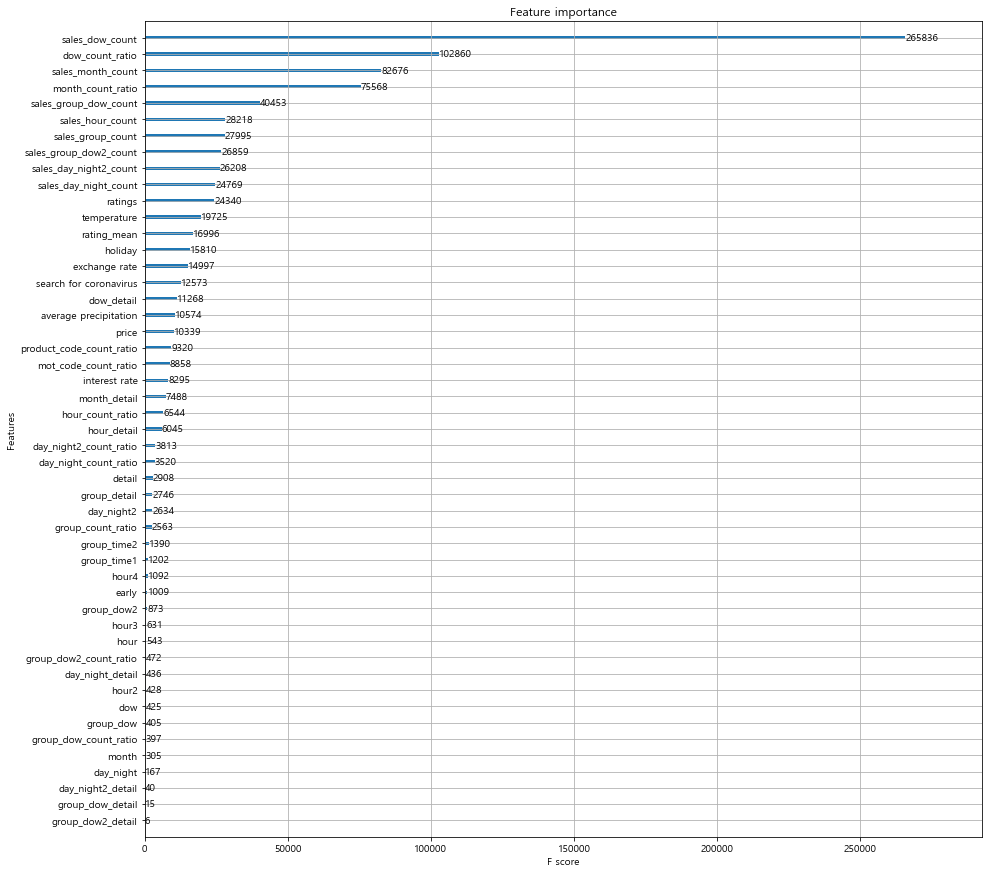

In [43]:
plt.rcParams["figure.figsize"] = (15, 15)
xgb.plot_importance(xgb_model1)

In [44]:
# CV MAE
# preds=[]
# for i in range(len(xgb_preds[0])):
#     sum=0
#     for j in range(K):
#         sum+=xgb_preds[j][i]
#     preds.append(sum / K)

# output = pd.DataFrame({'id': id_test, 'target': preds})

In [45]:
d_test = xgb.DMatrix(test_X)
xgb_pred = xgb_model1.predict(d_test)
xgb_pred

array([1215.2743  , 2217.7754  , 1376.2852  , ...,   53.59948 ,
         54.29038 ,   51.253307], dtype=float32)

In [46]:
df_xgb_pred1 = pd.DataFrame(xgb_pred)
df_xgb_pred1.columns = ['xgb_pred1']
df_xgb_pred1

,xgb_pred1
0,1215.274292
1,2217.775391
2,1376.285156
3,1061.367188
4,1821.965698
...,...
13286,31.994328
13287,21.451878
13288,53.599480
13289,54.290379


In [47]:
def MAPE(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

MAPE(test_y, xgb_pred)

0.5841144487935773

In [48]:
xgb_pred[xgb_pred < 0]

array([], dtype=float32)

### k-fold CV (LGBM1)

In [49]:
import lightgbm as lgb

In [50]:
# Model 1
for train_index, valid_index in kf.split(train):
    X_train, X_valid = train_X.iloc[train_index], train_X.iloc[valid_index]
    y_train, y_valid = train_y.iloc[train_index], train_y.iloc[valid_index]

    # params configuration also from the1owl's kernel
    # https://www.kaggle.com/the1owl/forza-baseline
    lgb_params = {'learning_rate': 0.001, 'boosting_type':'gbdt','max_depth': 10, 'min_gain_to_split':9,'min_sum_hessian_in_leaf':0.5217729, 'subsample': 0.8943889, 'colsample_bytree': 0.8936142, 
                  'objective': 'regression', 'metric': 'mape', 'seed': 42 , 'force_col_wise' : 'True' }

    d_train = lgb.Dataset(X_train, y_train)
    d_valid = lgb.Dataset(X_valid, y_valid)
    
    lgb_model1 = lgb.train(lgb_params, train_set = d_train, valid_sets = d_valid,  num_boost_round = 25000,
                          verbose_eval=100, early_stopping_rounds=200)
                        
#     lgb_pred = lgb_model.predict(X_valid)
#     lgb_preds.append(list(lgb_pred))
## Best parameter : list(booster="gbtree", eta=0.001, max_depth=10, min_child_weight=0.5217729, subsample=0.8943889, colsample_bytree=0.8936142, gamma=9)


[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Info] Total Bins 3811
[LightGBM] [Info] Number of data points in the train set: 17669, number of used features: 51
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 283.440636
Training until validation scores don't improve for 200 rounds
[100]	valid_0's mape: 8.79682
[200]	valid_0's mape: 7.97118
[300]	valid_0's mape: 7.22277
[400]	valid_0's mape: 6.54566
[500]	valid_0's mape: 5.93227
[600]	valid_0's mape: 5.37706
[700]	valid_0's mape: 4.87423
[800]	valid_0's mape: 4.41755
[900]	valid_0's mape: 4.00431
[1000]	valid_0's map

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10000]	valid_0's mape: 0.0139695
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11600]	valid_0's mape: 0.013084
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8500]	valid_0's mape: 0.0155707
[LightGBM] [Warning] No further splits with positive gain, best gai

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9400]	valid_0's mape: 0.0146729
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6800]	valid_0's mape: 0.0246383
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8200]	valid_0's mape: 0.0165446
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8800]	valid_0's mape: 0.0158896
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9300]	valid_0's mape: 0.0155167
[LightGBM] [Warning] No further splits with positive gain, best gai

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9800]	valid_0's mape: 0.0151474
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12800]	valid_0's mape: 0.0130465
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13700]	valid_0's mape: 0.012754
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14100]	valid_0's mape: 0.0126608
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14500]	valid_0's mape: 0.01261
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15000]	valid_0's mape: 0.0124998
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15400]	valid_0's mape: 0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7600]	valid_0's mape: 0.0173477
[LightGBM] [Warning] No further splits with positive gain, best gai

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8200]	valid_0's mape: 0.0151625
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8500]	valid_0's mape: 0.0146446
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9600]	valid_0's mape: 0.0138213
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11500]	valid_0's mape: 0.012851
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11900]	valid_0's mape: 0.0127991
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12300]	valid_0's mape: 0.0126642
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13100]	valid_0's mape: 0.0125046
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13800]	valid_0's mape: 0.0122394
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14200]	valid_0's mape: 0.0120615
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[6200]	valid_0's mape: 0.0377705
[6300]	valid_0's mape: 0.0354361
[6400]	valid_0's mape: 0.0332195
[6500]	valid_0's mape: 0.0311403
[6600]	valid_0's mape: 0.0292153
[6700]	valid_0's mape: 0.0276513
[6800]	valid_0's mape: 0.0262342
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6900]	valid_0's mape: 0.0248099
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7000]	valid_0's mape: 0.0235462
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7100]	valid_0's mape: 0.022

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7700]	valid_0's mape: 0.

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8800]	valid_0's mape: 0.0163231
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9700]	valid_0's mape: 0.0155817
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[10600]	valid_0's mape: 0.0149525
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11000]	valid_0's mape: 0.0147342
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11600]	valid_0's mape: 0.0143699
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [51]:
# LGBM은 predict할 때 lgb.Dataset 함수를 사용하지 않음
lgb_pred = lgb_model1.predict(test_X)
lgb_pred

array([1223.51506693, 2720.78217311, 1349.19404234, ...,   55.70038525,
         56.51096675,   58.53204257])

In [52]:
df_lgb_pred1 = pd.DataFrame(lgb_pred)
df_lgb_pred1.columns = ['lgb_pred1']
df_lgb_pred1

,lgb_pred1
0,1223.515067
1,2720.782173
2,1349.194042
3,1056.102347
4,2812.995506
...,...
13286,34.353444
13287,24.518454
13288,55.700385
13289,56.510967


In [53]:
MAPE(test_y, lgb_pred)  ## 과적합이 상당히 심함

2.5537077465503306

## train/test (Only 1) : 2번모델

In [54]:
train_idx = df_train[df_train['test']==1].index
train_1 = df_train.loc[train_idx]

print('train set dim: {}'.format(train_1.shape))

train set dim: (13291, 53)


In [55]:
df_xgb_pred1.set_index(train_idx,inplace = True)
df_lgb_pred1.set_index(train_idx,inplace = True)

In [56]:
train_1['xgb_pred1'] = df_xgb_pred1['xgb_pred1']
train_1['lgb_pred1'] = df_lgb_pred1['lgb_pred1']
train_1

,group,ratings,rating_mean,price,product_detail,sales,hour,dow,group_dow,group_dow2,...,group_dow_detail,group_dow2_detail,month_detail,search for coronavirus,exchange rate,interest rate,average precipitation,temperature,xgb_pred1,lgb_pred1
32,1,0.037,0.00760,0.004686,1,1218.176353,1,1,1,1,...,0.235813,0.139804,0.741388,0.504125,0.060578,1.0000,0.00625,0.198330,1215.274292,1223.515067
33,1,0.005,0.00050,0.004686,1,2313.767535,1,1,1,1,...,0.235813,0.139804,0.741388,0.504125,0.060578,1.0000,0.00625,0.188844,2217.775391,2720.782173
34,1,0.031,0.00305,0.006088,1,1375.295082,1,1,1,1,...,0.235813,0.139804,0.741388,0.504125,0.060578,1.0000,0.00625,0.188844,1376.285156,1349.194042
35,1,0.014,0.00070,0.003410,1,1061.281407,1,1,1,1,...,0.235813,0.139804,0.741388,0.504125,0.060578,1.0000,0.00625,0.179357,1061.367188,1056.102347
36,1,0.012,0.00085,0.003410,1,1846.582915,1,1,1,1,...,0.235813,0.139804,0.741388,0.504125,0.060578,1.0000,0.00625,0.170377,1821.965698,2812.995506
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35367,1,0.028,0.00515,0.170035,1,32.155997,1,1,1,1,...,0.235813,0.139804,1.000000,0.916590,0.430568,0.1875,0.05625,0.046926,31.994328,34.353444
35368,1,0.012,0.00060,0.187718,1,21.470314,1,1,1,1,...,0.235813,0.139804,1.000000,0.916590,0.430568,0.1875,0.05625,0.041993,21.451878,24.518454
35369,1,0.012,0.00060,0.170035,1,53.519500,1,1,1,1,...,0.235813,0.139804,1.000000,0.916590,0.430568,0.1875,0.05625,0.041993,53.599480,55.700385
35372,1,0.000,0.00000,0.019603,1,54.339286,1,1,1,1,...,0.235813,0.139804,1.000000,0.916590,0.430568,0.1875,0.05625,0.038199,54.290379,56.510967


# 요일별로 각각의 모델 만들기

In [58]:
# Model Monday
for train_index, valid_index in kf.split(mon_train_X,mon_train_y):
    X_train, X_valid = mon_train_X.iloc[train_index], mon_train_X.iloc[valid_index]
    y_train, y_valid = mon_train_y.iloc[train_index], mon_train_y.iloc[valid_index]

    xgb_params = {'eta': 0.001, 'max_depth': 10, 'gamma':9, 'subsample': 0.8943889, 'colsample_bytree': 0.8936142, 'min_child_weight':0.5217729,
                  'objective': 'reg:linear', 'eval_metric': 'mae', 'seed': 42, 'silent': True}

    d_train = xgb.DMatrix(X_train, y_train)
    d_valid = xgb.DMatrix(X_valid, y_valid)
    #d_test = xgb.DMatrix(test)
    
    
    watchlist = [(d_train, 'train'), (d_valid, 'valid')]
    xgb_model_mon = xgb.train(xgb_params, d_train,  25000,  watchlist, verbose_eval=100, early_stopping_rounds=200)
                        
#     xgb_pred = xgb_model.predict(d_valid)
#     xgb_preds.append(list(xgb_pred))
    
## Best parameter : list(booster="gbtree", eta=0.001, max_depth=10, min_child_weight=0.5217729, subsample=0.8943889, colsample_bytree=0.8936142, gamma=9)


d_test = xgb.DMatrix(mon_test_X)
xgb_pred_mon = xgb_model_mon.predict(d_test)
xgb_pred_mon

[09:21:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[09:21:39] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-mae:269.27844	valid-mae:260.33337
Multiple eval metrics have been passed: 'valid-mae' will be used for early stopping.

Will train until valid-mae hasn't improved in 200 rounds.
[100]	train-mae:243.90036	valid-mae:235.68979
[200]	train-mae:220.92871	valid-mae:213.32657
[300]	train-mae:200.13776	valid-mae:193.08745
[400]	train-mae:181.30397	valid-mae:174.77515
[500]	train-mae:164.24921	valid-mae:158.19861
[600]	train-mae:148.8

[5000]	train-mae:2.00776	valid-mae:2.03877
[5100]	train-mae:1.82675	valid-mae:1.86424
[5200]	train-mae:1.66202	valid-mae:1.70498
[5300]	train-mae:1.51275	valid-mae:1.56074
[5400]	train-mae:1.37729	valid-mae:1.43133
[5500]	train-mae:1.25421	valid-mae:1.31456
[5600]	train-mae:1.14266	valid-mae:1.20983
[5700]	train-mae:1.04144	valid-mae:1.11541
[5800]	train-mae:0.94936	valid-mae:1.02851
[5900]	train-mae:0.86569	valid-mae:0.95041
[6000]	train-mae:0.78932	valid-mae:0.87952
[6100]	train-mae:0.72035	valid-mae:0.81651
[6200]	train-mae:0.65771	valid-mae:0.76040
[6300]	train-mae:0.60074	valid-mae:0.71075
[6400]	train-mae:0.54903	valid-mae:0.66775
[6500]	train-mae:0.50234	valid-mae:0.62969
[6600]	train-mae:0.45999	valid-mae:0.59545
[6700]	train-mae:0.42167	valid-mae:0.56500
[6800]	train-mae:0.38670	valid-mae:0.53895
[6900]	train-mae:0.35466	valid-mae:0.51642
[7000]	train-mae:0.32564	valid-mae:0.49691
[7100]	train-mae:0.29955	valid-mae:0.48009
[7200]	train-mae:0.27610	valid-mae:0.46590
[7300]	trai

Will train until valid-mae hasn't improved in 200 rounds.
[100]	train-mae:238.60139	valid-mae:257.01138
[200]	train-mae:216.11848	valid-mae:232.82565
[300]	train-mae:195.76552	valid-mae:211.02125
[400]	train-mae:177.33269	valid-mae:191.31973
[500]	train-mae:160.64145	valid-mae:173.51059
[600]	train-mae:145.52264	valid-mae:157.40439
[700]	train-mae:131.82938	valid-mae:142.82158
[800]	train-mae:119.42825	valid-mae:129.59641
[900]	train-mae:108.19628	valid-mae:117.60912
[1000]	train-mae:98.02415	valid-mae:106.72976
[1100]	train-mae:88.81095	valid-mae:96.85500
[1200]	train-mae:80.46626	valid-mae:87.87782
[1300]	train-mae:72.90755	valid-mae:79.73561
[1400]	train-mae:66.06028	valid-mae:72.35197
[1500]	train-mae:59.85999	valid-mae:65.66847
[1600]	train-mae:54.24219	valid-mae:59.61832
[1700]	train-mae:49.15185	valid-mae:54.13196
[1800]	train-mae:44.54134	valid-mae:49.17018
[1900]	train-mae:40.36280	valid-mae:44.67283
[2000]	train-mae:36.57865	valid-mae:40.60074
[2100]	train-mae:33.14908	valid-

[1200]	train-mae:81.45763	valid-mae:83.39090
[1300]	train-mae:73.81313	valid-mae:75.56072
[1400]	train-mae:66.88998	valid-mae:68.46748
[1500]	train-mae:60.61669	valid-mae:62.04462
[1600]	train-mae:54.93361	valid-mae:56.21218
[1700]	train-mae:49.78484	valid-mae:50.92438
[1800]	train-mae:45.12015	valid-mae:46.12757
[1900]	train-mae:40.89414	valid-mae:41.77995
[2000]	train-mae:37.06527	valid-mae:37.83946
[2100]	train-mae:33.59753	valid-mae:34.27589
[2200]	train-mae:30.45488	valid-mae:31.03986
[2300]	train-mae:27.60863	valid-mae:28.11886
[2400]	train-mae:25.02892	valid-mae:25.46328
[2500]	train-mae:22.69162	valid-mae:23.06493
[2600]	train-mae:20.57386	valid-mae:20.89915
[2700]	train-mae:18.65518	valid-mae:18.94332
[2800]	train-mae:16.91652	valid-mae:17.17418
[2900]	train-mae:15.34157	valid-mae:15.56705
[3000]	train-mae:13.91392	valid-mae:14.10616
[3100]	train-mae:12.61956	valid-mae:12.78255
[3200]	train-mae:11.44597	valid-mae:11.57453
[3300]	train-mae:10.38265	valid-mae:10.45981
[3400]	tra

array([ 427.10455,  605.32745, 1108.3872 , ...,  670.57355, 1313.8309 ,
       1504.2029 ], dtype=float32)

In [60]:
xgb_pred_mon = pd.DataFrame(xgb_pred_mon)
xgb_pred_mon.columns = ['xgb_pred_dow']
xgb_pred_mon.set_index(mon_idx2,inplace = True)
xgb_pred_mon

,xgb_pred_dow
528,427.104553
529,605.327454
530,1108.387207
533,3.587042
534,29.298950
...,...
35269,174.059982
35270,225.449478
35271,670.573547
35272,1313.830933


In [61]:
MAPE(mon_test_y, xgb_pred_mon)

528            NaN
529            NaN
530            NaN
533            NaN
534            NaN
                ..
35270          NaN
35271          NaN
35272          NaN
35273          NaN
xgb_pred_dow   NaN
Length: 1672, dtype: float64

In [62]:
# Model tueday
for train_index, valid_index in kf.split(tue_train_X,tue_train_y):
    X_train, X_valid = tue_train_X.iloc[train_index], tue_train_X.iloc[valid_index]
    y_train, y_valid = tue_train_y.iloc[train_index], tue_train_y.iloc[valid_index]

    xgb_params = {'eta': 0.001, 'max_depth': 10, 'gamma':9, 'subsample': 0.8943889, 'colsample_bytree': 0.8936142, 'min_child_weight':0.5217729,
                  'objective': 'reg:linear', 'eval_metric': 'mae', 'seed': 42, 'silent': True}

    d_train = xgb.DMatrix(X_train, y_train)
    d_valid = xgb.DMatrix(X_valid, y_valid)
    #d_test = xgb.DMatrix(test)
    
    
    watchlist = [(d_train, 'train'), (d_valid, 'valid')]
    xgb_model_tue = xgb.train(xgb_params, d_train,  25000,  watchlist, verbose_eval=100, early_stopping_rounds=200)
                        
#     xgb_pred = xgb_model.predict(d_valid)
#     xgb_preds.append(list(xgb_pred))
    
## Best parameter : list(booster="gbtree", eta=0.001, max_depth=10, min_child_weight=0.5217729, subsample=0.8943889, colsample_bytree=0.8936142, gamma=9)


d_test = xgb.DMatrix(tue_test_X)
xgb_pred_tue = xgb_model_tue.predict(d_test)
xgb_pred_tue

[09:24:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[09:24:19] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-mae:275.60532	valid-mae:272.75906
Multiple eval metrics have been passed: 'valid-mae' will be used for early stopping.

Will train until valid-mae hasn't improved in 200 rounds.
[100]	train-mae:249.64751	valid-mae:247.12695
[200]	train-mae:226.13852	valid-mae:223.95067
[300]	train-mae:204.84486	valid-mae:202.94971
[400]	train-mae:185.55472	valid-mae:183.91921
[500]	train-mae:168.08369	valid-mae:166.71400
[600]	train-mae:152.2

[5400]	train-mae:1.35991	valid-mae:1.48118
[5500]	train-mae:1.23523	valid-mae:1.35643
[5600]	train-mae:1.12229	valid-mae:1.24319
[5700]	train-mae:1.01985	valid-mae:1.14049
[5800]	train-mae:0.92690	valid-mae:1.04697
[5900]	train-mae:0.84270	valid-mae:0.96174
[6000]	train-mae:0.76630	valid-mae:0.88538
[6100]	train-mae:0.69743	valid-mae:0.81658
[6200]	train-mae:0.63503	valid-mae:0.75542
[6300]	train-mae:0.57847	valid-mae:0.70086
[6400]	train-mae:0.52700	valid-mae:0.65236
[6500]	train-mae:0.48053	valid-mae:0.60986
[6600]	train-mae:0.43843	valid-mae:0.57223
[6700]	train-mae:0.40032	valid-mae:0.53917
[6800]	train-mae:0.36579	valid-mae:0.51001
[6900]	train-mae:0.33450	valid-mae:0.48435
[7000]	train-mae:0.30594	valid-mae:0.46142
[7100]	train-mae:0.27991	valid-mae:0.44226
[7200]	train-mae:0.25697	valid-mae:0.42575
[7300]	train-mae:0.23610	valid-mae:0.41094
[7400]	train-mae:0.21716	valid-mae:0.39766
[7500]	train-mae:0.20002	valid-mae:0.38602
[7600]	train-mae:0.18428	valid-mae:0.37583
[7700]	trai

[600]	train-mae:149.05542	valid-mae:164.75818
[700]	train-mae:135.02850	valid-mae:149.39087
[800]	train-mae:122.32050	valid-mae:135.48122
[900]	train-mae:110.81098	valid-mae:122.82420
[1000]	train-mae:100.38269	valid-mae:111.35300
[1100]	train-mae:90.94025	valid-mae:100.97938
[1200]	train-mae:82.38661	valid-mae:91.57945
[1300]	train-mae:74.64003	valid-mae:83.06671
[1400]	train-mae:67.62391	valid-mae:75.35366
[1500]	train-mae:61.26896	valid-mae:68.37174
[1600]	train-mae:55.51158	valid-mae:62.04950
[1700]	train-mae:50.29701	valid-mae:56.32133
[1800]	train-mae:45.57414	valid-mae:51.13399
[1900]	train-mae:41.29425	valid-mae:46.41784
[2000]	train-mae:37.41788	valid-mae:42.15057
[2100]	train-mae:33.90545	valid-mae:38.27734
[2200]	train-mae:30.72290	valid-mae:34.77237
[2300]	train-mae:27.84054	valid-mae:31.60053
[2400]	train-mae:25.22879	valid-mae:28.72164
[2500]	train-mae:22.86240	valid-mae:26.11048
[2600]	train-mae:20.71831	valid-mae:23.73931
[2700]	train-mae:18.77632	valid-mae:21.58468
[28

[4000]	train-mae:5.41933	valid-mae:4.85542
[4100]	train-mae:4.91467	valid-mae:4.39095
[4200]	train-mae:4.45733	valid-mae:3.97067
[4300]	train-mae:4.04303	valid-mae:3.59079
[4400]	train-mae:3.66753	valid-mae:3.24722
[4500]	train-mae:3.32715	valid-mae:2.93653
[4600]	train-mae:3.01824	valid-mae:2.65518
[4700]	train-mae:2.73822	valid-mae:2.40385
[4800]	train-mae:2.48436	valid-mae:2.17708
[4900]	train-mae:2.25430	valid-mae:1.97133
[5000]	train-mae:2.04582	valid-mae:1.78494
[5100]	train-mae:1.85665	valid-mae:1.61601
[5200]	train-mae:1.68553	valid-mae:1.46382
[5300]	train-mae:1.53047	valid-mae:1.32815
[5400]	train-mae:1.38959	valid-mae:1.20680
[5500]	train-mae:1.26183	valid-mae:1.09772
[5600]	train-mae:1.14623	valid-mae:1.00035
[5700]	train-mae:1.04155	valid-mae:0.91252
[5800]	train-mae:0.94653	valid-mae:0.83334
[5900]	train-mae:0.86057	valid-mae:0.76257
[6000]	train-mae:0.78246	valid-mae:0.69974
[6100]	train-mae:0.71176	valid-mae:0.64333
[6200]	train-mae:0.64809	valid-mae:0.59397
[6300]	trai

array([1217.3203 , 2022.7848 , 1374.5317 , ...,   53.4757 ,   54.36162,
         51.42269], dtype=float32)

In [63]:
xgb_pred_tue = pd.DataFrame(xgb_pred_tue)
xgb_pred_tue.columns = ['xgb_pred_dow']
xgb_pred_tue.set_index(tue_idx2,inplace = True)
xgb_pred_tue

,xgb_pred_dow
32,1217.320312
33,2022.784790
34,1374.531738
35,1060.725464
36,1827.419189
...,...
35367,32.041260
35368,21.507856
35369,53.475700
35372,54.361622


In [64]:
# Model wenday
for train_index, valid_index in kf.split(wen_train_X,wen_train_y):
    X_train, X_valid = wen_train_X.iloc[train_index], wen_train_X.iloc[valid_index]
    y_train, y_valid = wen_train_y.iloc[train_index], wen_train_y.iloc[valid_index]

    xgb_params = {'eta': 0.001, 'max_depth': 10, 'gamma':9, 'subsample': 0.8943889, 'colsample_bytree': 0.8936142, 'min_child_weight':0.5217729,
                  'objective': 'reg:linear', 'eval_metric': 'mae', 'seed': 42, 'silent': True}

    d_train = xgb.DMatrix(X_train, y_train)
    d_valid = xgb.DMatrix(X_valid, y_valid)
    #d_test = xgb.DMatrix(test)
    
    
    watchlist = [(d_train, 'train'), (d_valid, 'valid')]
    xgb_model_wen = xgb.train(xgb_params, d_train,  25000,  watchlist, verbose_eval=100, early_stopping_rounds=200)
                        
#     xgb_pred = xgb_model.predict(d_valid)
#     xgb_preds.append(list(xgb_pred))
    
## Best parameter : list(booster="gbtree", eta=0.001, max_depth=10, min_child_weight=0.5217729, subsample=0.8943889, colsample_bytree=0.8936142, gamma=9)


d_test = xgb.DMatrix(wen_test_X)
xgb_pred_wen = xgb_model_wen.predict(d_test)
xgb_pred_wen

[09:25:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[09:25:35] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-mae:269.06137	valid-mae:273.60236
Multiple eval metrics have been passed: 'valid-mae' will be used for early stopping.

Will train until valid-mae hasn't improved in 200 rounds.
[100]	train-mae:243.81110	valid-mae:247.81847
[200]	train-mae:220.96132	valid-mae:224.54982
[300]	train-mae:200.26082	valid-mae:203.49556
[400]	train-mae:181.51186	valid-mae:184.46239
[500]	train-mae:164.51930	valid-mae:167.20573
[600]	train-mae:149.1

[3900]	train-mae:6.11743	valid-mae:8.11046
[4000]	train-mae:5.56350	valid-mae:7.59338
[4100]	train-mae:5.06074	valid-mae:7.12539
[4200]	train-mae:4.60497	valid-mae:6.69788
[4300]	train-mae:4.19093	valid-mae:6.30999
[4400]	train-mae:3.81544	valid-mae:5.95573
[4500]	train-mae:3.47422	valid-mae:5.63524
[4600]	train-mae:3.16427	valid-mae:5.34715
[4700]	train-mae:2.88290	valid-mae:5.08212
[4800]	train-mae:2.62741	valid-mae:4.84437
[4900]	train-mae:2.39524	valid-mae:4.63116
[5000]	train-mae:2.18476	valid-mae:4.43684
[5100]	train-mae:1.99327	valid-mae:4.25822
[5200]	train-mae:1.81934	valid-mae:4.09828
[5300]	train-mae:1.66136	valid-mae:3.95081
[5400]	train-mae:1.51743	valid-mae:3.81574
[5500]	train-mae:1.38648	valid-mae:3.69372
[5600]	train-mae:1.26809	valid-mae:3.58726
[5700]	train-mae:1.16022	valid-mae:3.49072
[5800]	train-mae:1.06229	valid-mae:3.40331
[5900]	train-mae:0.97292	valid-mae:3.32531
[6000]	train-mae:0.89130	valid-mae:3.25398
[6100]	train-mae:0.81715	valid-mae:3.18974
[6200]	trai

[3600]	train-mae:8.14013	valid-mae:9.72085
[3700]	train-mae:7.40176	valid-mae:9.00479
[3800]	train-mae:6.73130	valid-mae:8.35933
[3900]	train-mae:6.12281	valid-mae:7.77460
[4000]	train-mae:5.57001	valid-mae:7.24573
[4100]	train-mae:5.06855	valid-mae:6.76830
[4200]	train-mae:4.61382	valid-mae:6.33243
[4300]	train-mae:4.20102	valid-mae:5.93477
[4400]	train-mae:3.82613	valid-mae:5.57026
[4500]	train-mae:3.48553	valid-mae:5.24113
[4600]	train-mae:3.17682	valid-mae:4.94242
[4700]	train-mae:2.89595	valid-mae:4.67288
[4800]	train-mae:2.64062	valid-mae:4.43226
[4900]	train-mae:2.40867	valid-mae:4.21571
[5000]	train-mae:2.19740	valid-mae:4.02559
[5100]	train-mae:2.00600	valid-mae:3.85304
[5200]	train-mae:1.83231	valid-mae:3.69669
[5300]	train-mae:1.67413	valid-mae:3.55232
[5400]	train-mae:1.53019	valid-mae:3.41956
[5500]	train-mae:1.39943	valid-mae:3.30015
[5600]	train-mae:1.28036	valid-mae:3.19136
[5700]	train-mae:1.17221	valid-mae:3.09443
[5800]	train-mae:1.07387	valid-mae:3.00751
[5900]	trai

[3900]	train-mae:5.96973	valid-mae:6.62630
[4000]	train-mae:5.42467	valid-mae:6.07016
[4100]	train-mae:4.92952	valid-mae:5.56776
[4200]	train-mae:4.48140	valid-mae:5.11533
[4300]	train-mae:4.07500	valid-mae:4.71007
[4400]	train-mae:3.70561	valid-mae:4.34297
[4500]	train-mae:3.37062	valid-mae:4.00980
[4600]	train-mae:3.06748	valid-mae:3.70814
[4700]	train-mae:2.79320	valid-mae:3.43464
[4800]	train-mae:2.54352	valid-mae:3.18696
[4900]	train-mae:2.31666	valid-mae:2.96241
[5000]	train-mae:2.11095	valid-mae:2.76005
[5100]	train-mae:1.92420	valid-mae:2.58536
[5200]	train-mae:1.75440	valid-mae:2.42894
[5300]	train-mae:1.59996	valid-mae:2.28765
[5400]	train-mae:1.45995	valid-mae:2.16197
[5500]	train-mae:1.33315	valid-mae:2.05299
[5600]	train-mae:1.21804	valid-mae:1.95647
[5700]	train-mae:1.11373	valid-mae:1.87165
[5800]	train-mae:1.01854	valid-mae:1.79612
[5900]	train-mae:0.93111	valid-mae:1.72578
[6000]	train-mae:0.85171	valid-mae:1.66323
[6100]	train-mae:0.77974	valid-mae:1.60742
[6200]	trai

[6900]	train-mae:0.40127	valid-mae:1.28491
[7000]	train-mae:0.36997	valid-mae:1.27130
[7100]	train-mae:0.34110	valid-mae:1.25960
[7200]	train-mae:0.31531	valid-mae:1.25042
[7300]	train-mae:0.29184	valid-mae:1.24225
[7400]	train-mae:0.27020	valid-mae:1.23519
[7500]	train-mae:0.25051	valid-mae:1.22921
[7600]	train-mae:0.23288	valid-mae:1.22458
[7700]	train-mae:0.21679	valid-mae:1.22102
[7800]	train-mae:0.20215	valid-mae:1.21873
[7900]	train-mae:0.18890	valid-mae:1.21663
[8000]	train-mae:0.17656	valid-mae:1.21501
[8100]	train-mae:0.16528	valid-mae:1.21365
[8200]	train-mae:0.15491	valid-mae:1.21264
[8300]	train-mae:0.14548	valid-mae:1.21157
[8400]	train-mae:0.13751	valid-mae:1.21127
[8500]	train-mae:0.12990	valid-mae:1.21109
[8600]	train-mae:0.12311	valid-mae:1.21111
Stopping. Best iteration:
[8490]	train-mae:0.13059	valid-mae:1.21105

[09:27:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor 

array([ 6.8340096, 42.46918  , 13.282992 , ..., 19.723886 , 19.723886 ,
       11.289275 ], dtype=float32)

In [65]:
xgb_pred_wen = pd.DataFrame(xgb_pred_wen)
xgb_pred_wen.columns = ['xgb_pred_dow']
xgb_pred_wen.set_index(wen_idx2,inplace = True)
xgb_pred_wen

,xgb_pred_dow
93,6.834010
94,42.469181
95,13.282992
96,9.962687
97,48.756313
...,...
35344,5.732533
35345,16.927271
35346,19.723886
35347,19.723886


In [66]:
# Model thuday
for train_index, valid_index in kf.split(thu_train_X,thu_train_y):
    X_train, X_valid = thu_train_X.iloc[train_index], thu_train_X.iloc[valid_index]
    y_train, y_valid = thu_train_y.iloc[train_index], thu_train_y.iloc[valid_index]

    xgb_params = {'eta': 0.001, 'max_depth': 10, 'gamma':9, 'subsample': 0.8943889, 'colsample_bytree': 0.8936142, 'min_child_weight':0.5217729,
                  'objective': 'reg:linear', 'eval_metric': 'mae', 'seed': 42, 'silent': True}

    d_train = xgb.DMatrix(X_train, y_train)
    d_valid = xgb.DMatrix(X_valid, y_valid)
    #d_test = xgb.DMatrix(test)
    
    
    watchlist = [(d_train, 'train'), (d_valid, 'valid')]
    xgb_model_thu = xgb.train(xgb_params, d_train,  25000,  watchlist, verbose_eval=100, early_stopping_rounds=200)
                        
#     xgb_pred = xgb_model.predict(d_valid)
#     xgb_preds.append(list(xgb_pred))
    
## Best parameter : list(booster="gbtree", eta=0.001, max_depth=10, min_child_weight=0.5217729, subsample=0.8943889, colsample_bytree=0.8936142, gamma=9)


d_test = xgb.DMatrix(thu_test_X)
xgb_pred_thu = xgb_model_thu.predict(d_test)
xgb_pred_thu

[09:27:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[09:27:22] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-mae:272.55264	valid-mae:280.62958
Multiple eval metrics have been passed: 'valid-mae' will be used for early stopping.

Will train until valid-mae hasn't improved in 200 rounds.
[100]	train-mae:246.91594	valid-mae:254.43102
[200]	train-mae:223.69192	valid-mae:230.61728
[300]	train-mae:202.65991	valid-mae:209.02940
[400]	train-mae:183.61287	valid-mae:189.43198
[500]	train-mae:166.36009	valid-mae:171.65002
[600]	train-mae:150.7

[6200]	train-mae:0.68701	valid-mae:1.11245
[6300]	train-mae:0.62737	valid-mae:1.06735
[6400]	train-mae:0.57346	valid-mae:1.02710
[6500]	train-mae:0.52464	valid-mae:0.99241
[6600]	train-mae:0.48040	valid-mae:0.96186
[6700]	train-mae:0.44013	valid-mae:0.93514
[6800]	train-mae:0.40366	valid-mae:0.91123
[6900]	train-mae:0.37027	valid-mae:0.89028
[7000]	train-mae:0.33999	valid-mae:0.87247
[7100]	train-mae:0.31288	valid-mae:0.85743
[7200]	train-mae:0.28807	valid-mae:0.84410
[7300]	train-mae:0.26519	valid-mae:0.83247
[7400]	train-mae:0.24461	valid-mae:0.82283
[7500]	train-mae:0.22624	valid-mae:0.81479
[7600]	train-mae:0.20957	valid-mae:0.80786
[7700]	train-mae:0.19457	valid-mae:0.80193
[7800]	train-mae:0.18064	valid-mae:0.79658
[7900]	train-mae:0.16775	valid-mae:0.79185
[8000]	train-mae:0.15625	valid-mae:0.78801
[8100]	train-mae:0.14604	valid-mae:0.78505
[8200]	train-mae:0.13660	valid-mae:0.78242
[8300]	train-mae:0.12809	valid-mae:0.78031
[8400]	train-mae:0.12023	valid-mae:0.77845
[8500]	trai

[13500]	train-mae:0.06170	valid-mae:0.93196
[13600]	train-mae:0.06157	valid-mae:0.93157
[13700]	train-mae:0.06147	valid-mae:0.93117
[13800]	train-mae:0.06140	valid-mae:0.93082
[13900]	train-mae:0.06132	valid-mae:0.93047
[14000]	train-mae:0.06125	valid-mae:0.93014
[14100]	train-mae:0.06116	valid-mae:0.92980
[14200]	train-mae:0.06108	valid-mae:0.92947
[14300]	train-mae:0.06100	valid-mae:0.92918
[14400]	train-mae:0.06092	valid-mae:0.92888
[14500]	train-mae:0.06086	valid-mae:0.92862
[14600]	train-mae:0.06080	valid-mae:0.92837
[14700]	train-mae:0.06085	valid-mae:0.92838
[14800]	train-mae:0.06091	valid-mae:0.92839
Stopping. Best iteration:
[14600]	train-mae:0.06080	valid-mae:0.92837

[09:28:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[09:28:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now 

[1900]	train-mae:42.54042	valid-mae:40.26530
[2000]	train-mae:38.56850	valid-mae:36.46597
[2100]	train-mae:34.96887	valid-mae:33.02598
[2200]	train-mae:31.70738	valid-mae:29.91545
[2300]	train-mae:28.75126	valid-mae:27.09617
[2400]	train-mae:26.07257	valid-mae:24.54448
[2500]	train-mae:23.64363	valid-mae:22.23240
[2600]	train-mae:21.44373	valid-mae:20.13776
[2700]	train-mae:19.44958	valid-mae:18.23905
[2800]	train-mae:17.64081	valid-mae:16.52007
[2900]	train-mae:16.00094	valid-mae:14.96283
[3000]	train-mae:14.51424	valid-mae:13.55355
[3100]	train-mae:13.16743	valid-mae:12.27948
[3200]	train-mae:11.94559	valid-mae:11.12554
[3300]	train-mae:10.83847	valid-mae:10.08082
[3400]	train-mae:9.83454	valid-mae:9.13515
[3500]	train-mae:8.92334	valid-mae:8.27719
[3600]	train-mae:8.09814	valid-mae:7.49964
[3700]	train-mae:7.34891	valid-mae:6.79355
[3800]	train-mae:6.66967	valid-mae:6.15360
[3900]	train-mae:6.05367	valid-mae:5.57356
[4000]	train-mae:5.49521	valid-mae:5.04867
[4100]	train-mae:4.98850

array([514.84955 , 675.5509  , 881.472   , ...,  39.14774 ,  19.776932,
        30.820711], dtype=float32)

In [67]:
xgb_pred_thu = pd.DataFrame(xgb_pred_thu)
xgb_pred_thu.columns = ['xgb_pred_dow']
xgb_pred_thu.set_index(thu_idx2,inplace = True)
xgb_pred_thu

,xgb_pred_dow
171,514.849548
172,675.550903
173,881.471985
188,762.469360
189,1053.687866
...,...
34972,587.156006
34973,1292.687500
35349,39.147739
35350,19.776932


In [68]:
# Model friday
for train_index, valid_index in kf.split(fri_train_X,fri_train_y):
    X_train, X_valid = fri_train_X.iloc[train_index], fri_train_X.iloc[valid_index]
    y_train, y_valid = fri_train_y.iloc[train_index], fri_train_y.iloc[valid_index]

    xgb_params = {'eta': 0.001, 'max_depth': 10, 'gamma':9, 'subsample': 0.8943889, 'colsample_bytree': 0.8936142, 'min_child_weight':0.5217729,
                  'objective': 'reg:linear', 'eval_metric': 'mae', 'seed': 42, 'silent': True}

    d_train = xgb.DMatrix(X_train, y_train)
    d_valid = xgb.DMatrix(X_valid, y_valid)
    #d_test = xgb.DMatrix(test)
    
    
    watchlist = [(d_train, 'train'), (d_valid, 'valid')]
    xgb_model_fri = xgb.train(xgb_params, d_train,  25000,  watchlist, verbose_eval=100, early_stopping_rounds=200)
                        
#     xgb_pred = xgb_model.predict(d_valid)
#     xgb_preds.append(list(xgb_pred))
    
## Best parameter : list(booster="gbtree", eta=0.001, max_depth=10, min_child_weight=0.5217729, subsample=0.8943889, colsample_bytree=0.8936142, gamma=9)


d_test = xgb.DMatrix(fri_test_X)
xgb_pred_fri = xgb_model_fri.predict(d_test)
xgb_pred_fri

[09:28:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[09:28:45] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-mae:277.37463	valid-mae:277.92789
Multiple eval metrics have been passed: 'valid-mae' will be used for early stopping.

Will train until valid-mae hasn't improved in 200 rounds.
[100]	train-mae:251.25122	valid-mae:251.72040
[200]	train-mae:227.61379	valid-mae:227.94704
[300]	train-mae:206.21166	valid-mae:206.44197
[400]	train-mae:186.82321	valid-mae:186.98105
[500]	train-mae:169.27164	valid-mae:169.38591
[600]	train-mae:153.3

[5500]	train-mae:1.26233	valid-mae:3.93076
[5600]	train-mae:1.14662	valid-mae:3.81960
[5700]	train-mae:1.04179	valid-mae:3.71903
[5800]	train-mae:0.94685	valid-mae:3.62861
[5900]	train-mae:0.86078	valid-mae:3.54810
[6000]	train-mae:0.78298	valid-mae:3.47595
[6100]	train-mae:0.71251	valid-mae:3.41158
[6200]	train-mae:0.64849	valid-mae:3.35376
[6300]	train-mae:0.59063	valid-mae:3.30240
[6400]	train-mae:0.53822	valid-mae:3.25724
[6500]	train-mae:0.49076	valid-mae:3.21757
[6600]	train-mae:0.44775	valid-mae:3.18261
[6700]	train-mae:0.40868	valid-mae:3.15089
[6800]	train-mae:0.37320	valid-mae:3.12270
[6900]	train-mae:0.34091	valid-mae:3.09815
[7000]	train-mae:0.31198	valid-mae:3.07673
[7100]	train-mae:0.28605	valid-mae:3.05864
[7200]	train-mae:0.26249	valid-mae:3.04280
[7300]	train-mae:0.24094	valid-mae:3.02905
[7400]	train-mae:0.22153	valid-mae:3.01719
[7500]	train-mae:0.20408	valid-mae:3.00711
[7600]	train-mae:0.18810	valid-mae:2.99812
[7700]	train-mae:0.17396	valid-mae:2.99057
[7800]	trai

Multiple eval metrics have been passed: 'valid-mae' will be used for early stopping.

Will train until valid-mae hasn't improved in 200 rounds.
[100]	train-mae:249.17685	valid-mae:260.13623
[200]	train-mae:225.70879	valid-mae:235.77304
[300]	train-mae:204.46960	valid-mae:213.68205
[400]	train-mae:185.23375	valid-mae:193.65601
[500]	train-mae:167.82632	valid-mae:175.43796
[600]	train-mae:152.06453	valid-mae:158.90048
[700]	train-mae:137.79739	valid-mae:143.93610
[800]	train-mae:124.86752	valid-mae:130.35776
[900]	train-mae:113.15787	valid-mae:118.02583
[1000]	train-mae:102.55054	valid-mae:106.85583
[1100]	train-mae:92.94309	valid-mae:96.85028
[1200]	train-mae:84.23992	valid-mae:87.80579
[1300]	train-mae:76.35640	valid-mae:79.62041
[1400]	train-mae:69.21351	valid-mae:72.20631
[1500]	train-mae:62.74311	valid-mae:65.48370
[1600]	train-mae:56.88053	valid-mae:59.38874
[1700]	train-mae:51.56822	valid-mae:53.85069
[1800]	train-mae:46.75659	valid-mae:48.82581
[1900]	train-mae:42.39563	valid-mae

[9200]	train-mae:0.09610	valid-mae:0.22347
[9300]	train-mae:0.09382	valid-mae:0.22359
Stopping. Best iteration:
[9135]	train-mae:0.09777	valid-mae:0.22343

[09:29:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.


array([   6.836081,   22.858446,    6.839001, ..., 1020.38983 ,
       1606.853   , 1912.5077  ], dtype=float32)

In [69]:
xgb_pred_fri = pd.DataFrame(xgb_pred_fri)
xgb_pred_fri.columns = ['xgb_pred_dow']
xgb_pred_fri.set_index(fri_idx2,inplace = True)
xgb_pred_fri

,xgb_pred_dow
265,6.836081
266,22.858446
267,6.839001
268,10.133200
269,22.788698
...,...
35048,1193.754517
35049,1832.520874
35050,1020.389832
35051,1606.853027


In [70]:
# Model satday
for train_index, valid_index in kf.split(sat_train_X,sat_train_y):
    X_train, X_valid = sat_train_X.iloc[train_index], sat_train_X.iloc[valid_index]
    y_train, y_valid = sat_train_y.iloc[train_index], sat_train_y.iloc[valid_index]

    xgb_params = {'eta': 0.001, 'max_depth': 10, 'gamma':9, 'subsample': 0.8943889, 'colsample_bytree': 0.8936142, 'min_child_weight':0.5217729,
                  'objective': 'reg:linear', 'eval_metric': 'mae', 'seed': 42, 'silent': True}

    d_train = xgb.DMatrix(X_train, y_train)
    d_valid = xgb.DMatrix(X_valid, y_valid)
    #d_test = xgb.DMatrix(test)
    
    
    watchlist = [(d_train, 'train'), (d_valid, 'valid')]
    xgb_model_sat = xgb.train(xgb_params, d_train,  25000,  watchlist, verbose_eval=100, early_stopping_rounds=200)
                        
#     xgb_pred = xgb_model.predict(d_valid)
#     xgb_preds.append(list(xgb_pred))
    
## Best parameter : list(booster="gbtree", eta=0.001, max_depth=10, min_child_weight=0.5217729, subsample=0.8943889, colsample_bytree=0.8936142, gamma=9)


d_test = xgb.DMatrix(sat_test_X)
xgb_pred_sat = xgb_model_sat.predict(d_test)
xgb_pred_sat

[09:29:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[09:29:55] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-mae:322.32016	valid-mae:312.32593
Multiple eval metrics have been passed: 'valid-mae' will be used for early stopping.

Will train until valid-mae hasn't improved in 200 rounds.
[100]	train-mae:292.19772	valid-mae:282.83432
[200]	train-mae:264.90433	valid-mae:256.16476
[300]	train-mae:240.19394	valid-mae:231.98328
[400]	train-mae:217.79106	valid-mae:210.06735
[500]	train-mae:197.48796	valid-mae:190.25179
[600]	train-mae:179.0

[2600]	train-mae:25.79302	valid-mae:25.12206
[2700]	train-mae:23.44032	valid-mae:22.93298
[2800]	train-mae:21.30536	valid-mae:20.94449
[2900]	train-mae:19.36984	valid-mae:19.14095
[3000]	train-mae:17.61205	valid-mae:17.50775
[3100]	train-mae:16.01590	valid-mae:16.03018
[3200]	train-mae:14.56655	valid-mae:14.69241
[3300]	train-mae:13.25329	valid-mae:13.47670
[3400]	train-mae:12.05935	valid-mae:12.37319
[3500]	train-mae:10.97628	valid-mae:11.37097
[3600]	train-mae:9.99230	valid-mae:10.46107
[3700]	train-mae:9.09845	valid-mae:9.63232
[3800]	train-mae:8.28695	valid-mae:8.88077
[3900]	train-mae:7.55032	valid-mae:8.19635
[4000]	train-mae:6.88011	valid-mae:7.57368
[4100]	train-mae:6.27197	valid-mae:7.00967
[4200]	train-mae:5.71837	valid-mae:6.50044
[4300]	train-mae:5.21551	valid-mae:6.03880
[4400]	train-mae:4.75841	valid-mae:5.62007
[4500]	train-mae:4.34227	valid-mae:5.24183
[4600]	train-mae:3.96451	valid-mae:4.89569
[4700]	train-mae:3.62120	valid-mae:4.58049
[4800]	train-mae:3.30840	valid-ma

[4900]	train-mae:3.01192	valid-mae:2.52325
[5000]	train-mae:2.75545	valid-mae:2.29266
[5100]	train-mae:2.52155	valid-mae:2.08751
[5200]	train-mae:2.30893	valid-mae:1.90175
[5300]	train-mae:2.11525	valid-mae:1.73594
[5400]	train-mae:1.93939	valid-mae:1.58754
[5500]	train-mae:1.77929	valid-mae:1.45421
[5600]	train-mae:1.63297	valid-mae:1.33391
[5700]	train-mae:1.50009	valid-mae:1.22534
[5800]	train-mae:1.37916	valid-mae:1.12756
[5900]	train-mae:1.26869	valid-mae:1.04175
[6000]	train-mae:1.16848	valid-mae:0.96625
[6100]	train-mae:1.07671	valid-mae:0.89823
[6200]	train-mae:0.99262	valid-mae:0.83808
[6300]	train-mae:0.91636	valid-mae:0.78591
[6400]	train-mae:0.84711	valid-mae:0.74008
[6500]	train-mae:0.78351	valid-mae:0.69895
[6600]	train-mae:0.72532	valid-mae:0.66209
[6700]	train-mae:0.67223	valid-mae:0.62956
[6800]	train-mae:0.62331	valid-mae:0.60127
[6900]	train-mae:0.57831	valid-mae:0.57708
[7000]	train-mae:0.53791	valid-mae:0.55722
[7100]	train-mae:0.50082	valid-mae:0.54040
[7200]	trai

[09:31:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[09:31:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[09:31:06] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-mae:315.82257	valid-mae:338.32376
Multiple eval metrics have been passed: 'valid-mae' will be used for early stopping.

Will train until valid-mae hasn't improved in 200 rounds.
[100]	train-mae:286.12772	valid-mae:308.01288
[200]	train-mae:259.23224	va

array([ 725.743 , 1065.2571, 1139.9365, ..., 1047.4729, 2007.3428,
       2139.8472], dtype=float32)

In [71]:
xgb_pred_sat = pd.DataFrame(xgb_pred_sat)
xgb_pred_sat.columns = ['xgb_pred_dow']
xgb_pred_sat.set_index(sat_idx2,inplace = True)
xgb_pred_sat

,xgb_pred_dow
374,725.742981
375,1065.257080
376,1139.936523
377,1306.872681
378,1946.651123
...,...
35113,119.529869
35117,148.566879
35138,1047.472900
35139,2007.342773


In [72]:
# Model sunday
for train_index, valid_index in kf.split(sun_train_X,sun_train_y):
    X_train, X_valid = sun_train_X.iloc[train_index], sun_train_X.iloc[valid_index]
    y_train, y_valid = sun_train_y.iloc[train_index], sun_train_y.iloc[valid_index]

    xgb_params = {'eta': 0.001, 'max_depth': 10, 'gamma':9, 'subsample': 0.8943889, 'colsample_bytree': 0.8936142, 'min_child_weight':0.5217729,
                  'objective': 'reg:linear', 'eval_metric': 'mae', 'seed': 42, 'silent': True}

    d_train = xgb.DMatrix(X_train, y_train)
    d_valid = xgb.DMatrix(X_valid, y_valid)
    #d_test = xgb.DMatrix(test)
    
    
    watchlist = [(d_train, 'train'), (d_valid, 'valid')]
    xgb_model_sun = xgb.train(xgb_params, d_train,  25000,  watchlist, verbose_eval=100, early_stopping_rounds=200)
                        
#     xgb_pred = xgb_model.predict(d_valid)
#     xgb_preds.append(list(xgb_pred))
    
## Best parameter : list(booster="gbtree", eta=0.001, max_depth=10, min_child_weight=0.5217729, subsample=0.8943889, colsample_bytree=0.8936142, gamma=9)


d_test = xgb.DMatrix(sun_test_X)
xgb_pred_sun = xgb_model_sun.predict(d_test)
xgb_pred_sun

[09:31:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[09:31:29] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-mae:295.53732	valid-mae:293.91379
Multiple eval metrics have been passed: 'valid-mae' will be used for early stopping.

Will train until valid-mae hasn't improved in 200 rounds.
[100]	train-mae:267.72565	valid-mae:266.24313
[200]	train-mae:242.55048	valid-mae:241.19321
[300]	train-mae:219.74896	valid-mae:218.50146
[400]	train-mae:199.09883	valid-mae:197.95868
[500]	train-mae:180.39629	valid-mae:179.36801
[600]	train-mae:163.4

[5500]	train-mae:1.39201	valid-mae:1.69423
[5600]	train-mae:1.26875	valid-mae:1.55923
[5700]	train-mae:1.15672	valid-mae:1.43614
[5800]	train-mae:1.05519	valid-mae:1.32607
[5900]	train-mae:0.96279	valid-mae:1.22732
[6000]	train-mae:0.87887	valid-mae:1.13718
[6100]	train-mae:0.80245	valid-mae:1.05537
[6200]	train-mae:0.73323	valid-mae:0.98269
[6300]	train-mae:0.67064	valid-mae:0.91730
[6400]	train-mae:0.61377	valid-mae:0.85848
[6500]	train-mae:0.56188	valid-mae:0.80447
[6600]	train-mae:0.51500	valid-mae:0.75632
[6700]	train-mae:0.47231	valid-mae:0.71312
[6800]	train-mae:0.43369	valid-mae:0.67465
[6900]	train-mae:0.39850	valid-mae:0.64031
[7000]	train-mae:0.36641	valid-mae:0.60951
[7100]	train-mae:0.33728	valid-mae:0.58226
[7200]	train-mae:0.31075	valid-mae:0.55863
[7300]	train-mae:0.28638	valid-mae:0.53758
[7400]	train-mae:0.26461	valid-mae:0.51883
[7500]	train-mae:0.24449	valid-mae:0.50205
[7600]	train-mae:0.22657	valid-mae:0.48692
[7700]	train-mae:0.21033	valid-mae:0.47316
[7800]	trai

[13700]	train-mae:0.06530	valid-mae:0.78412
[13800]	train-mae:0.06513	valid-mae:0.78405
[13900]	train-mae:0.06494	valid-mae:0.78398
[14000]	train-mae:0.06492	valid-mae:0.78399
Stopping. Best iteration:
[13826]	train-mae:0.06495	valid-mae:0.78398

[09:32:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[09:32:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.2.0/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[09:32:16] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-mae:2

[4100]	train-mae:5.28543	valid-mae:5.40997
[4200]	train-mae:4.79843	valid-mae:4.92704
[4300]	train-mae:4.35665	valid-mae:4.48876
[4400]	train-mae:3.95604	valid-mae:4.08991
[4500]	train-mae:3.59331	valid-mae:3.72897
[4600]	train-mae:3.26434	valid-mae:3.40166
[4700]	train-mae:2.96569	valid-mae:3.10582
[4800]	train-mae:2.69488	valid-mae:2.83865
[4900]	train-mae:2.44981	valid-mae:2.59652
[5000]	train-mae:2.22752	valid-mae:2.37696
[5100]	train-mae:2.02595	valid-mae:2.17794
[5200]	train-mae:1.84306	valid-mae:1.99802
[5300]	train-mae:1.67724	valid-mae:1.83490
[5400]	train-mae:1.52688	valid-mae:1.68832
[5500]	train-mae:1.38976	valid-mae:1.55634
[5600]	train-mae:1.26592	valid-mae:1.43876
[5700]	train-mae:1.15348	valid-mae:1.33320
[5800]	train-mae:1.05117	valid-mae:1.23857
[5900]	train-mae:0.95864	valid-mae:1.15441
[6000]	train-mae:0.87425	valid-mae:1.07973
[6100]	train-mae:0.79749	valid-mae:1.01224
[6200]	train-mae:0.72793	valid-mae:0.95267
[6300]	train-mae:0.66511	valid-mae:0.89946
[6400]	trai

array([ 701.5735  , 1343.6133  , 1313.0103  , ...,   34.826218,
          3.818195,  147.51155 ], dtype=float32)

In [73]:
xgb_pred_sun = pd.DataFrame(xgb_pred_sun)
xgb_pred_sun.columns = ['xgb_pred_dow']
xgb_pred_sun.set_index(sun_idx2,inplace = True)
xgb_pred_sun

,xgb_pred_dow
426,701.573486
427,1343.613281
428,1313.010254
464,972.466858
465,1385.093140
...,...
35206,100.130898
35207,3.706836
35208,34.826218
35209,3.818195


In [74]:
xgb_pred_dow = pd.concat([xgb_pred_mon,xgb_pred_tue,xgb_pred_wen,xgb_pred_thu,xgb_pred_fri,xgb_pred_sat,xgb_pred_sun],axis = 0)
xgb_pred_dow.sort_index(inplace = True)

In [75]:
# min-max scaling
train_1['xgb_pred1'] = (train_1['xgb_pred1'] - train_1['xgb_pred1'].min()) / (train_1['xgb_pred1'].max() - train_1['xgb_pred1'].min())
train_1['lgb_pred1'] = (train_1['lgb_pred1'] - train_1['lgb_pred1'].min()) / (train_1['lgb_pred1'].max() - train_1['lgb_pred1'].min())

In [76]:
train_1['xgb_pred_dow'] = (xgb_pred_dow -xgb_pred_dow.min()) / (xgb_pred_dow.max() - xgb_pred_dow.min()) 
train_1

,group,ratings,rating_mean,price,product_detail,sales,hour,dow,group_dow,group_dow2,...,group_dow2_detail,month_detail,search for coronavirus,exchange rate,interest rate,average precipitation,temperature,xgb_pred1,lgb_pred1,xgb_pred_dow
32,1,0.037,0.00760,0.004686,1,1218.176353,1,1,1,1,...,0.139804,0.741388,0.504125,0.060578,1.0000,0.00625,0.198330,0.242967,0.298645,0.380973
33,1,0.005,0.00050,0.004686,1,2313.767535,1,1,1,1,...,0.139804,0.741388,0.504125,0.060578,1.0000,0.00625,0.188844,0.443682,0.664782,0.633547
34,1,0.031,0.00305,0.006088,1,1375.295082,1,1,1,1,...,0.139804,0.741388,0.504125,0.060578,1.0000,0.00625,0.188844,0.275204,0.329378,0.430271
35,1,0.014,0.00070,0.003410,1,1061.281407,1,1,1,1,...,0.139804,0.741388,0.504125,0.060578,1.0000,0.00625,0.179357,0.212153,0.257706,0.331869
36,1,0.012,0.00085,0.003410,1,1846.582915,1,1,1,1,...,0.139804,0.741388,0.504125,0.060578,1.0000,0.00625,0.170377,0.364435,0.687331,0.572285
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35367,1,0.028,0.00515,0.170035,1,32.155997,1,1,1,1,...,0.139804,1.000000,0.916590,0.430568,0.1875,0.05625,0.046926,0.006059,0.007851,0.009298
35368,1,0.012,0.00060,0.187718,1,21.470314,1,1,1,1,...,0.139804,1.000000,0.916590,0.430568,0.1875,0.05625,0.041993,0.003948,0.005446,0.005995
35369,1,0.012,0.00060,0.170035,1,53.519500,1,1,1,1,...,0.139804,1.000000,0.916590,0.430568,0.1875,0.05625,0.041993,0.010384,0.013071,0.016020
35372,1,0.000,0.00000,0.019603,1,54.339286,1,1,1,1,...,0.139804,1.000000,0.916590,0.430568,0.1875,0.05625,0.038199,0.010523,0.013269,0.016297


In [77]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(train_1, train_1['sales'], test_size=0.2, shuffle=True, random_state=42) 

train_X.drop(columns = ['sales','test'],inplace = True)
test_X.drop(columns = ['sales','test'],inplace = True)
print('train set dim: {}'.format(train_X.shape))
print('test set dim: {}'.format(test_X.shape))

train set dim: (10632, 54)
test set dim: (2659, 54)


### k-fold CV (XGBOOST) STACKING FINAL MODEL

In [263]:
%time
for train_index, valid_index in kf.split(train_X):            
    X_train, X_valid = train_X.iloc[train_index], train_X.iloc[valid_index]
    y_train, y_valid = train_y.iloc[train_index], train_y.iloc[valid_index]

    # params configuration also from the1owl's kernel
    # https://www.kaggle.com/the1owl/forza-baseline
    xgb_params = {'eta': 0.001, 'max_depth': 10, 'gamma':9, 'subsample': 0.8943889, 'colsample_bytree':0.8936142 ,'min_child_weight':0.5217729,
                  'objective': 'reg:linear', 'eval_metric': 'mae', 'seed': 42, 'silent': False} # 'booster' : 'dart'

    d_train = xgb.DMatrix(X_train, y_train)
    d_valid = xgb.DMatrix(X_valid, y_valid)
    #d_test = xgb.DMatrix(test)
    
    watchlist = [(d_train, 'train'), (d_valid, 'valid')]
    xgb_model_final = xgb.train(xgb_params, d_train,  25000,  watchlist, verbose_eval=100, early_stopping_rounds=200) # feval = MAPE ,maximize = False
                        
#     xgb_pred = xgb_model.predict(d_valid)
#     xgb_preds.append(list(xgb_pred))
#'subsample': 0.8943889, 'colsample_bytree': 0.8936142, 'min_child_weight':0.5217729,

Wall time: 0 ns
[05:22:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-mae:362.388	valid-mae:380.606
Multiple eval metrics have been passed: 'valid-mae' will be used for early stopping.

Will train until valid-mae hasn't improved in 200 rounds.
[100]	train-mae:328.091	valid-mae:344.74
[200]	train-mae:297.043	valid-mae:312.26
[300]	train-mae:268.937	valid-mae:282.847
[400]	train-mae:243.494	valid-mae:256.227
[500]	train-mae:220.463	valid-mae:232.117
[600]	train-mae:199.608	valid-mae:210.295
[700]	train-mae:180.73	valid-mae:190.527
[800]	train-mae:163.638	valid-mae:172.624
[900]	train-mae:148.164	valid-mae:156.423
[1000]	train-mae:134.155	valid-mae:141.764
[1100]	train-mae:121.47	valid-mae:128.488
[1200]	train-mae:109.987	valid-mae:116.469
[1300]	train-mae:99.5922	valid-mae:105.58
[1400]	train-mae:90.1819	valid-mae:95.7242
[1500]	train-mae:81.6623	valid-mae:86.798
[1600]

[18000]	train-mae:0.173781	valid-mae:2.08045
[18100]	train-mae:0.173637	valid-mae:2.08041
[18200]	train-mae:0.17351	valid-mae:2.08037
[18300]	train-mae:0.173419	valid-mae:2.08033
[18400]	train-mae:0.17329	valid-mae:2.08028
[18500]	train-mae:0.173177	valid-mae:2.08024
[18600]	train-mae:0.173059	valid-mae:2.08019
[18700]	train-mae:0.172945	valid-mae:2.08016
[18800]	train-mae:0.172824	valid-mae:2.08013
[18900]	train-mae:0.172721	valid-mae:2.08009
[19000]	train-mae:0.172653	valid-mae:2.08006
[19100]	train-mae:0.172536	valid-mae:2.08001
[19200]	train-mae:0.172428	valid-mae:2.07997
[19300]	train-mae:0.172344	valid-mae:2.07991
[19400]	train-mae:0.172263	valid-mae:2.07987
[19500]	train-mae:0.172145	valid-mae:2.07982
[19600]	train-mae:0.17204	valid-mae:2.0798
[19700]	train-mae:0.171959	valid-mae:2.07978
[19800]	train-mae:0.171845	valid-mae:2.07974
[19900]	train-mae:0.171718	valid-mae:2.0797
[20000]	train-mae:0.171655	valid-mae:2.07967
[20100]	train-mae:0.171548	valid-mae:2.07963
[20200]	train-m

[10900]	train-mae:0.207651	valid-mae:1.27232
[11000]	train-mae:0.206321	valid-mae:1.27156
[11100]	train-mae:0.205131	valid-mae:1.27092
[11200]	train-mae:0.203963	valid-mae:1.27023
[11300]	train-mae:0.202843	valid-mae:1.26961
[11400]	train-mae:0.20176	valid-mae:1.26902
[11500]	train-mae:0.200664	valid-mae:1.26852
[11600]	train-mae:0.199715	valid-mae:1.26796
[11700]	train-mae:0.198764	valid-mae:1.26747
[11800]	train-mae:0.197878	valid-mae:1.26702
[11900]	train-mae:0.196998	valid-mae:1.26652
[12000]	train-mae:0.196202	valid-mae:1.26608
[12100]	train-mae:0.195488	valid-mae:1.26568
[12200]	train-mae:0.194678	valid-mae:1.26526
[12300]	train-mae:0.19407	valid-mae:1.26492
[12400]	train-mae:0.193401	valid-mae:1.26459
[12500]	train-mae:0.1928	valid-mae:1.26426
[12600]	train-mae:0.192226	valid-mae:1.26395
[12700]	train-mae:0.191686	valid-mae:1.26359
[12800]	train-mae:0.191211	valid-mae:1.26332
[12900]	train-mae:0.190674	valid-mae:1.26303
[13000]	train-mae:0.190167	valid-mae:1.2628
[13100]	train-m

[3600]	train-mae:10.4595	valid-mae:10.1429
[3700]	train-mae:9.48351	valid-mae:9.24081
[3800]	train-mae:8.6	valid-mae:8.4233
[3900]	train-mae:7.79997	valid-mae:7.68442
[4000]	train-mae:7.07585	valid-mae:7.01594
[4100]	train-mae:6.41948	valid-mae:6.41381
[4200]	train-mae:5.82547	valid-mae:5.87172
[4300]	train-mae:5.28753	valid-mae:5.3845
[4400]	train-mae:4.80015	valid-mae:4.94911
[4500]	train-mae:4.35867	valid-mae:4.55246
[4600]	train-mae:3.95908	valid-mae:4.19501
[4700]	train-mae:3.59652	valid-mae:3.87305
[4800]	train-mae:3.26832	valid-mae:3.58366
[4900]	train-mae:2.97101	valid-mae:3.32488
[5000]	train-mae:2.70158	valid-mae:3.09514
[5100]	train-mae:2.45729	valid-mae:2.88792
[5200]	train-mae:2.23585	valid-mae:2.70202
[5300]	train-mae:2.03509	valid-mae:2.53471
[5400]	train-mae:1.85327	valid-mae:2.38448
[5500]	train-mae:1.68864	valid-mae:2.25107
[5600]	train-mae:1.53982	valid-mae:2.13223
[5700]	train-mae:1.40534	valid-mae:2.02689
[5800]	train-mae:1.28391	valid-mae:1.93269
[5900]	train-mae:

[22200]	train-mae:0.173817	valid-mae:1.26512
[22300]	train-mae:0.173744	valid-mae:1.2651
[22400]	train-mae:0.173656	valid-mae:1.26507
[22500]	train-mae:0.173571	valid-mae:1.26504
[22600]	train-mae:0.173479	valid-mae:1.26501
[22700]	train-mae:0.173386	valid-mae:1.26498
[22800]	train-mae:0.173294	valid-mae:1.26495
[22900]	train-mae:0.173236	valid-mae:1.26494
[23000]	train-mae:0.17319	valid-mae:1.26493
[23100]	train-mae:0.173114	valid-mae:1.26491
[23200]	train-mae:0.173032	valid-mae:1.26489
[23300]	train-mae:0.172939	valid-mae:1.26486
[23400]	train-mae:0.17285	valid-mae:1.26483
[23500]	train-mae:0.172787	valid-mae:1.26481
[23600]	train-mae:0.172721	valid-mae:1.2648
[23700]	train-mae:0.172659	valid-mae:1.26479
[23800]	train-mae:0.172559	valid-mae:1.26474
[23900]	train-mae:0.172483	valid-mae:1.2647
[24000]	train-mae:0.17239	valid-mae:1.26468
[24100]	train-mae:0.172343	valid-mae:1.26467
[24200]	train-mae:0.172272	valid-mae:1.26464
[24300]	train-mae:0.172208	valid-mae:1.26462
[24400]	train-ma

[15100]	train-mae:0.180262	valid-mae:1.18078
[15200]	train-mae:0.179943	valid-mae:1.18064
[15300]	train-mae:0.17965	valid-mae:1.18051
[15400]	train-mae:0.179423	valid-mae:1.18042
[15500]	train-mae:0.179172	valid-mae:1.18032
[15600]	train-mae:0.178928	valid-mae:1.18021
[15700]	train-mae:0.178657	valid-mae:1.18009
[15800]	train-mae:0.178347	valid-mae:1.17994
[15900]	train-mae:0.17808	valid-mae:1.17985
[16000]	train-mae:0.177875	valid-mae:1.17977
[16100]	train-mae:0.177706	valid-mae:1.17971
[16200]	train-mae:0.177481	valid-mae:1.1796
[16300]	train-mae:0.177259	valid-mae:1.1795
[16400]	train-mae:0.177052	valid-mae:1.1794
[16500]	train-mae:0.17684	valid-mae:1.17928
[16600]	train-mae:0.176666	valid-mae:1.1792
[16700]	train-mae:0.176439	valid-mae:1.1791
[16800]	train-mae:0.176248	valid-mae:1.179
[16900]	train-mae:0.176064	valid-mae:1.17892
[17000]	train-mae:0.175897	valid-mae:1.17883
[17100]	train-mae:0.175729	valid-mae:1.17875
[17200]	train-mae:0.175563	valid-mae:1.17866
[17300]	train-mae:0.

[8000]	train-mae:0.312799	valid-mae:1.87759
[8100]	train-mae:0.303093	valid-mae:1.87458
[8200]	train-mae:0.294448	valid-mae:1.87204
[8300]	train-mae:0.286904	valid-mae:1.87003
[8400]	train-mae:0.279969	valid-mae:1.86803
[8500]	train-mae:0.273788	valid-mae:1.86632
[8600]	train-mae:0.26823	valid-mae:1.86478
[8700]	train-mae:0.263237	valid-mae:1.8634
[8800]	train-mae:0.258624	valid-mae:1.86225
[8900]	train-mae:0.254172	valid-mae:1.86111
[9000]	train-mae:0.250047	valid-mae:1.85982
[9100]	train-mae:0.246325	valid-mae:1.85882
[9200]	train-mae:0.242974	valid-mae:1.85786
[9300]	train-mae:0.239772	valid-mae:1.85697
[9400]	train-mae:0.236953	valid-mae:1.85624
[9500]	train-mae:0.234183	valid-mae:1.85549
[9600]	train-mae:0.231625	valid-mae:1.85479
[9700]	train-mae:0.229252	valid-mae:1.85408
[9800]	train-mae:0.227094	valid-mae:1.85346
[9900]	train-mae:0.225043	valid-mae:1.85281
[10000]	train-mae:0.223053	valid-mae:1.85219
[10100]	train-mae:0.221478	valid-mae:1.85175
[10200]	train-mae:0.219978	valid

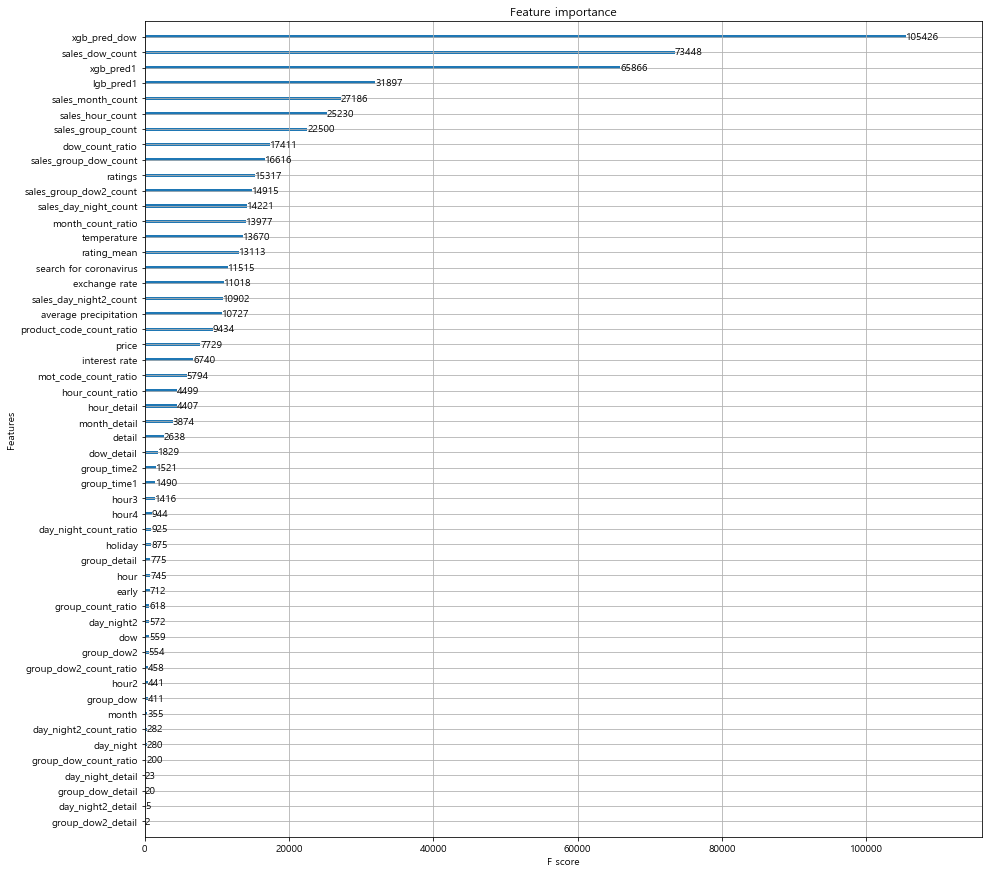

In [264]:
plt.rcParams["figure.figsize"] = (15, 15)
xgb.plot_importance(xgb_model_final)

In [265]:
d_test = xgb.DMatrix(test_X)
xgb_pred_final = xgb_model_final.predict(d_test)
xgb_pred_final

array([  13.444525 ,   46.292347 ,  621.826    , ...,   47.45391  ,
       1606.9865   ,    5.2460933], dtype=float32)

In [266]:
MAPE(test_y, xgb_pred_final)

0.2925831275661391

In [460]:
xgb_pred[xgb_pred < 0]

array([], dtype=float32)

In [263]:
train_1.columns

Index(['group', 'ratings', 'rating_mean', 'price', 'product_detail', 'sales',
       'hour', 'dow', 'group_dow', 'group_dow2', 'early', 'day_night',
       'group_time1', 'group_time2', 'detail', 'test', 'day_night2', 'holiday',
       'month', 'hour2', 'hour3', 'hour4', 'sales_group_count',
       'sales_hour_count', 'sales_dow_count', 'sales_day_night_count',
       'sales_day_night2_count', 'sales_group_dow_count',
       'sales_group_dow2_count', 'sales_month_count', 'dow_count_ratio',
       'group_dow_count_ratio', 'group_count_ratio', 'group_dow2_count_ratio',
       'hour_count_ratio', 'day_night_count_ratio', 'mot_code_count_ratio',
       'product_code_count_ratio', 'day_night2_count_ratio',
       'month_count_ratio', 'group_detail', 'hour_detail', 'dow_detail',
       'day_night_detail', 'day_night2_detail', 'group_dow_detail',
       'group_dow2_detail', 'month_detail', 'search for coronavirus',
       'exchange rate', 'interest rate', 'average precipitation',
       'temp

# 판매량 구분을 위한 클러스터링

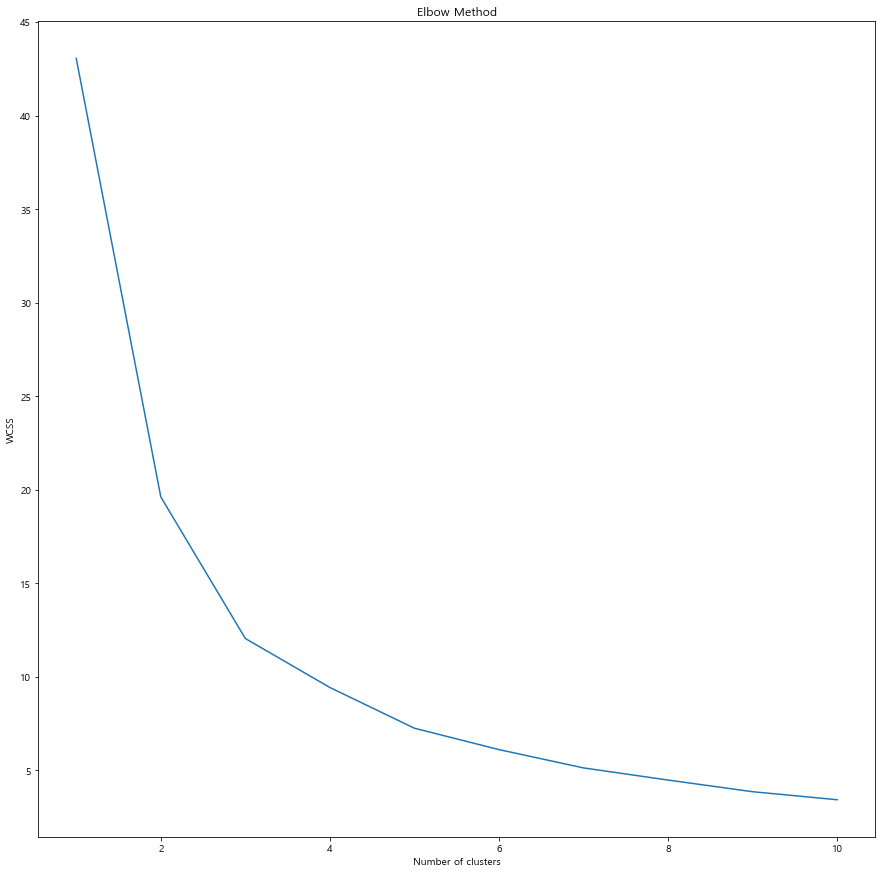

In [293]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(train_1[['ratings','sales_group_count']])
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()



In [294]:
kmeans = KMeans(n_clusters=8, init='k-means++', max_iter=300, n_init=10, random_state=0)
train_1['rating_max_group_cluster'] = kmeans.fit_predict(train_1[['ratings','sales_group_count']])

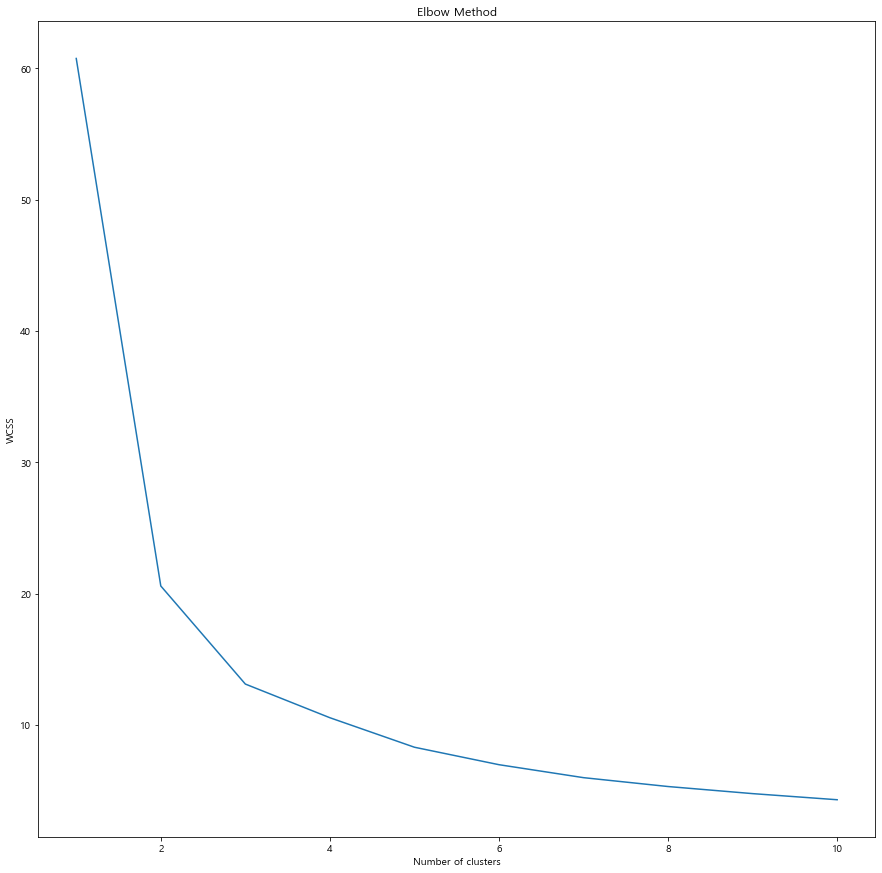

In [278]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(train_1[['ratings','sales_dow_count']])
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()


In [295]:
kmeans = KMeans(n_clusters=6, init='k-means++', max_iter=300, n_init=10, random_state=0)
train_1['rating_max_dow_cluster'] = kmeans.fit_predict(train_1[['ratings','sales_dow_count']])

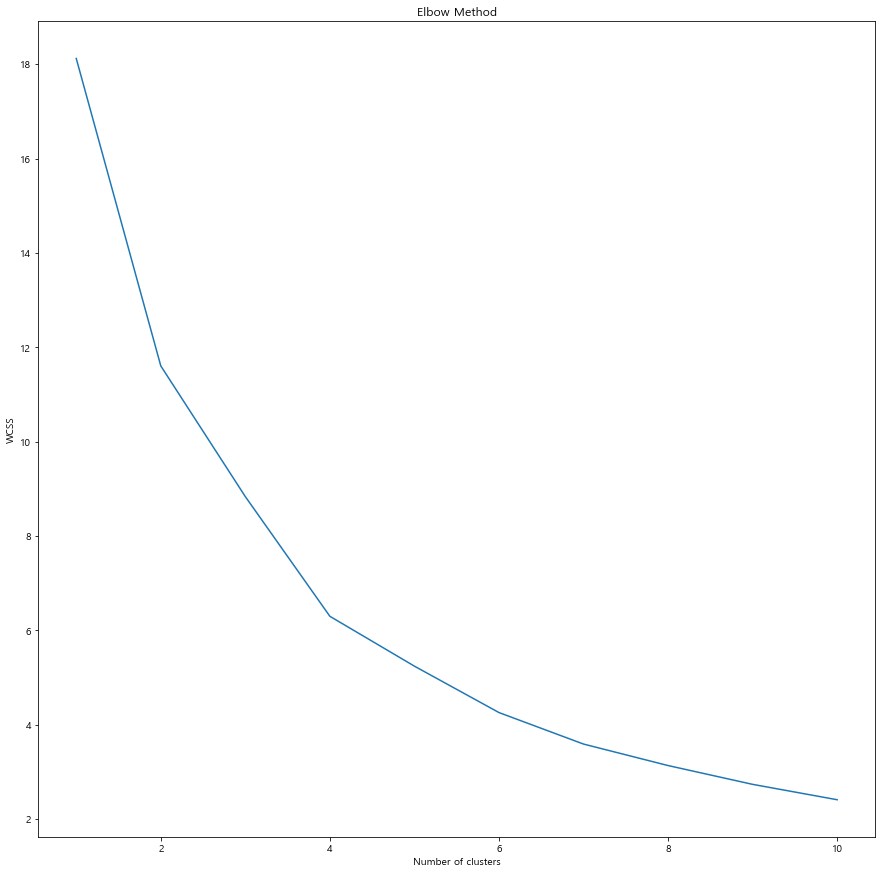

In [280]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(train_1[['ratings','sales_hour_count']])
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [296]:
kmeans = KMeans(n_clusters=8, init='k-means++', max_iter=300, n_init=10, random_state=0)
train_1['rating_max_hour_cluster'] = kmeans.fit_predict(train_1[['ratings','sales_hour_count']])

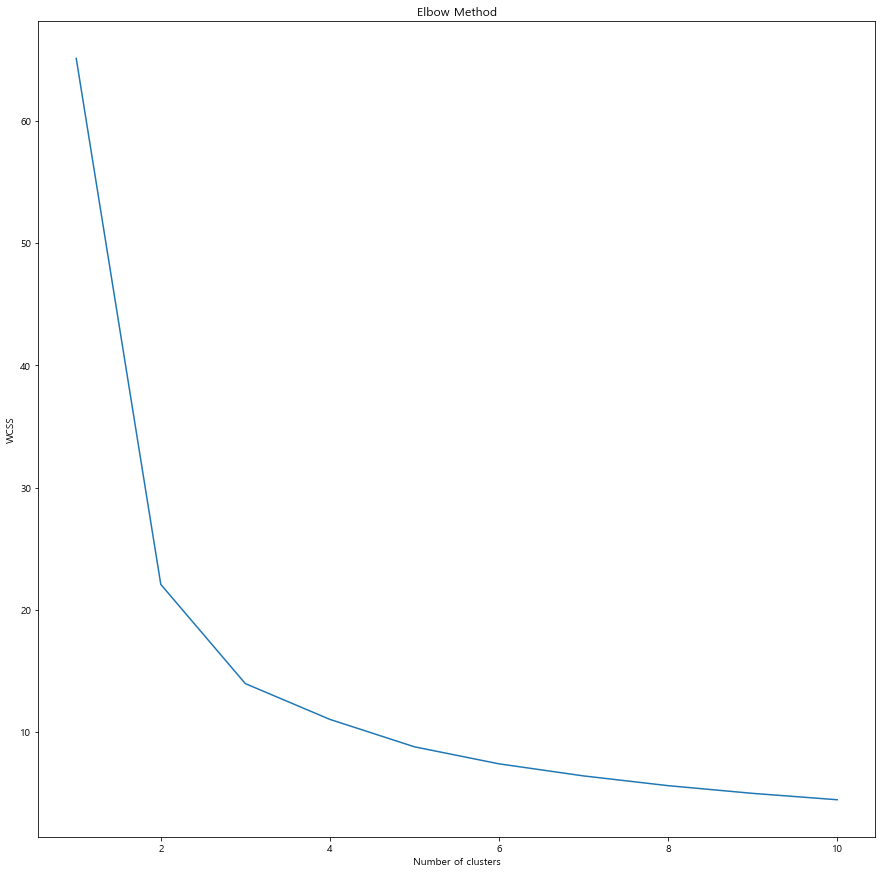

In [282]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(train_1[['ratings','sales_month_count']])
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [297]:
kmeans = KMeans(n_clusters=6, init='k-means++', max_iter=300, n_init=10, random_state=0)
train_1['rating_max_month_cluster'] = kmeans.fit_predict(train_1[['ratings','sales_month_count']])

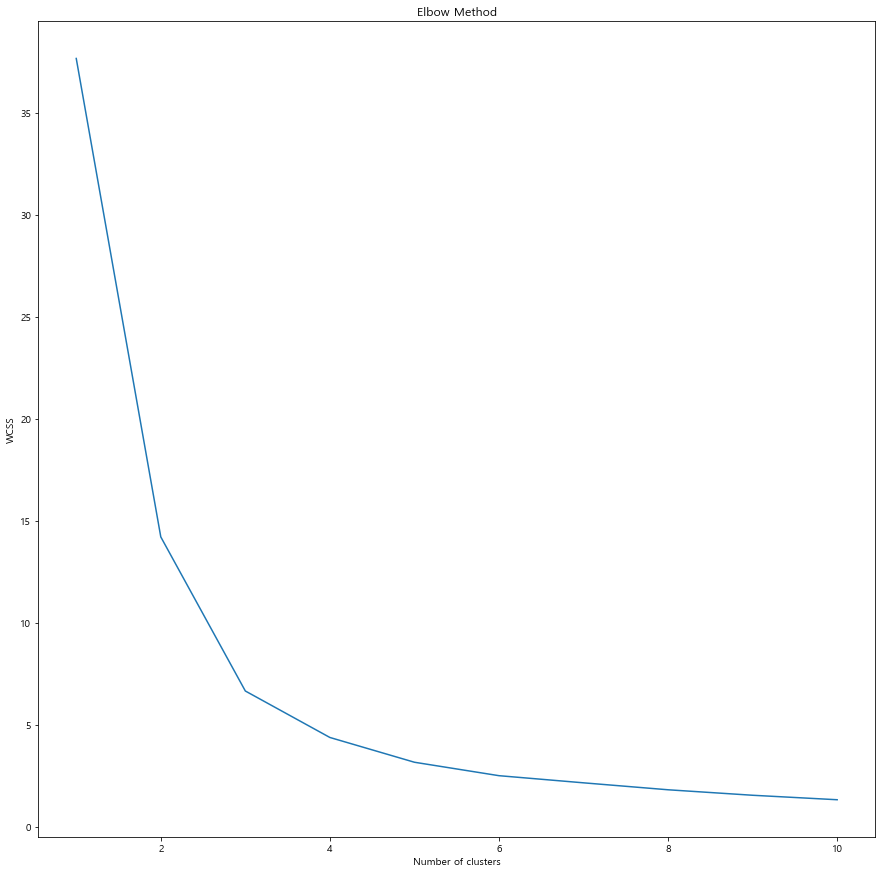

In [275]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(train_1[['rating_mean','sales_group_count']])
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()


In [298]:
kmeans = KMeans(n_clusters=6, init='k-means++', max_iter=300, n_init=10, random_state=0)
train_1['rating_mean_group_cluster'] = kmeans.fit_predict(train_1[['rating_mean','sales_group_count']])

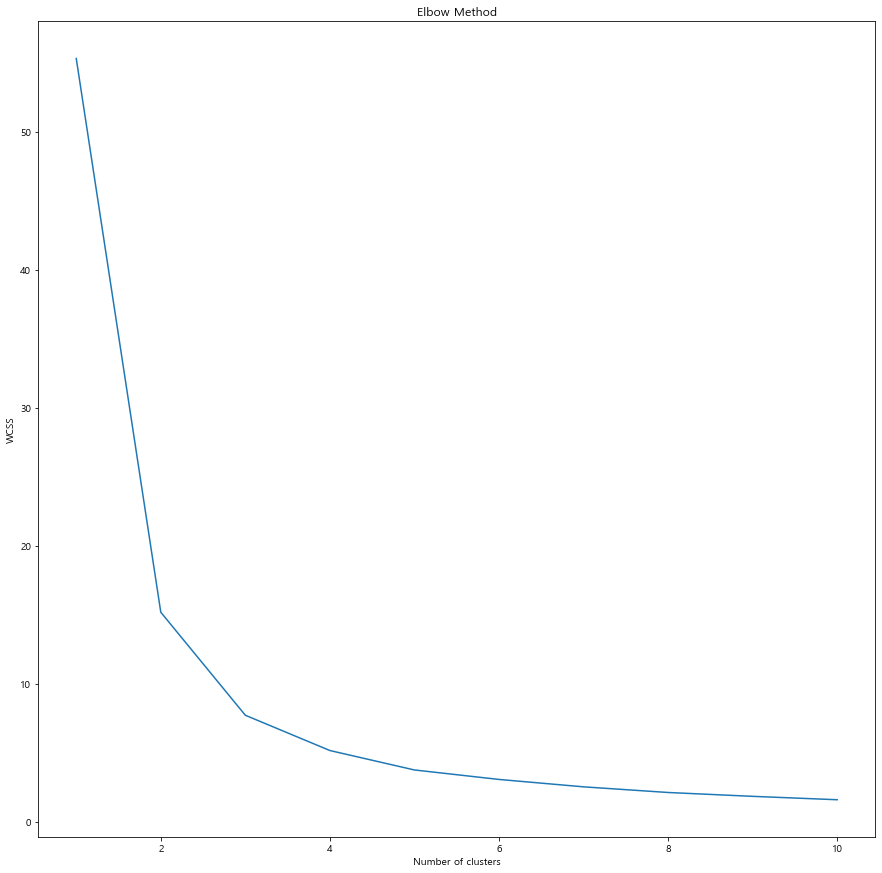

In [285]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(train_1[['rating_mean','sales_dow_count']])
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [299]:
kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=300, n_init=10, random_state=0)
train_1['rating_mean_dow_cluster'] = kmeans.fit_predict(train_1[['rating_mean','sales_dow_count']])

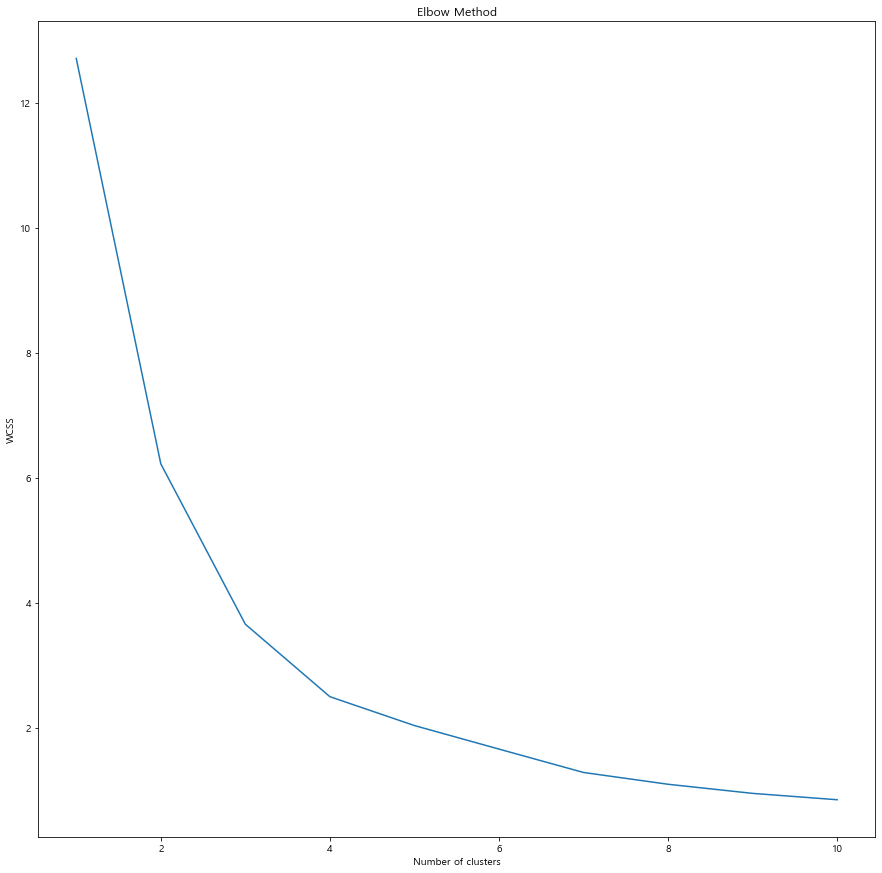

In [288]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(train_1[['rating_mean','sales_hour_count']])
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [300]:
kmeans = KMeans(n_clusters=7, init='k-means++', max_iter=300, n_init=10, random_state=0)
train_1['rating_mean_hour_cluster'] = kmeans.fit_predict(train_1[['rating_mean','sales_hour_count']])

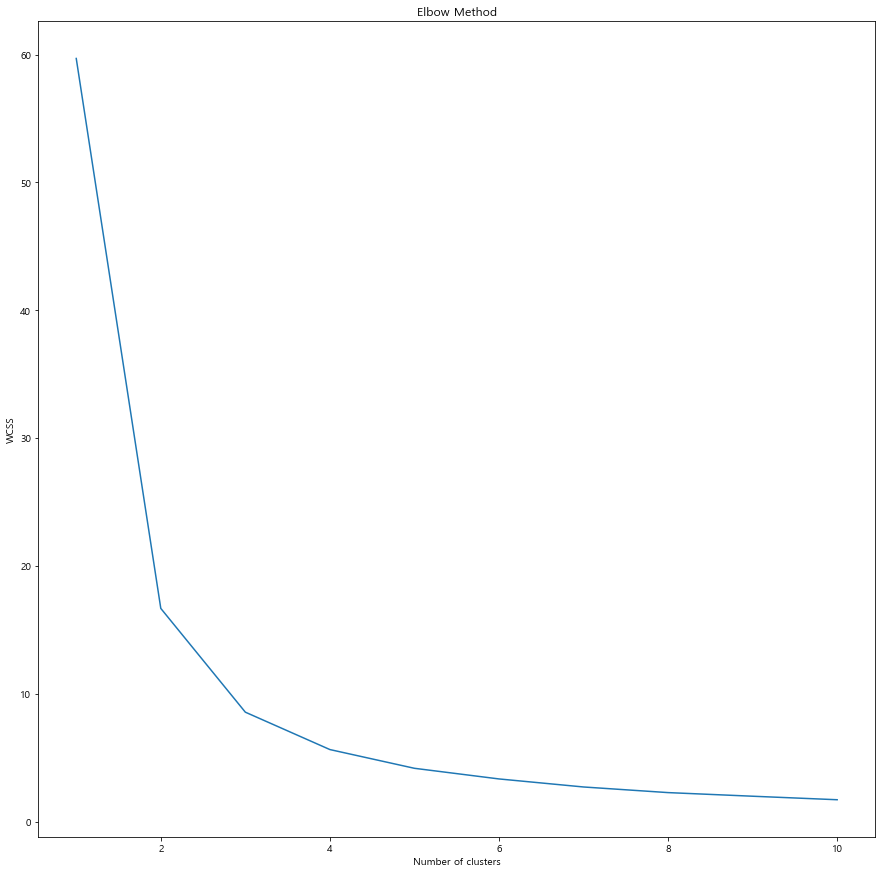

In [290]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(train_1[['rating_mean','sales_month_count']])
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [301]:
kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=300, n_init=10, random_state=0)
train_1['rating_mean_month_cluster'] = kmeans.fit_predict(train_1[['rating_mean','sales_month_count']])

In [302]:
train_1

,group,ratings,rating_mean,price,product_detail,sales,hour,dow,group_dow,group_dow2,...,rating_max_cluster,rating_mean_cluster,rating_max_group_cluster,rating_max_dow_cluster,rating_max_hour_cluster,rating_max_month_cluster,rating_mean_group_cluster,rating_mean_dow_cluster,rating_mean_hour_cluster,rating_mean_month_cluster
32,1,0.037,0.00760,0.004686,수산,1218.176353,1,1,1,1,...,4,3,6,2,5,4,1,2,5,3
33,1,0.005,0.00050,0.004686,수산,2313.767535,1,1,1,1,...,1,1,1,3,5,1,2,3,2,1
34,1,0.031,0.00305,0.006088,농산,1375.295082,1,1,1,1,...,4,3,6,1,5,4,1,2,5,3
35,1,0.014,0.00070,0.003410,남성화장품,1061.281407,1,1,1,1,...,2,3,1,2,0,2,2,2,5,3
36,1,0.012,0.00085,0.003410,남성화장품,1846.582915,1,1,1,1,...,4,1,3,1,5,4,5,3,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35367,1,0.028,0.00515,0.170035,냉장고,32.155997,1,1,1,1,...,0,0,4,4,4,0,0,1,1,0
35368,1,0.012,0.00060,0.187718,냉장고,21.470314,1,1,1,1,...,5,0,0,0,1,5,0,1,1,0
35369,1,0.012,0.00060,0.170035,냉장고,53.519500,1,1,1,1,...,5,0,0,0,1,5,0,1,1,0
35372,1,0.000,0.00000,0.019603,밥솥,54.339286,1,1,1,1,...,5,0,0,0,1,5,0,1,1,0


# test set 완성(하는중)

In [247]:
test_set = pd.read_excel('test202006.xlsx')

In [248]:
test_set.columns

Index(['date', 'exposure', 'mot_code', 'product_code', 'product_name',
       'product_detail', 'group', 'price', 'tot_price', 'hour', 'dow', 'month',
       'group_time2', 'group_time1', 'early', 'detail', 'day_night',
       'group_dow', 'search for coronavirus', 'exchange rate', 'interest rate',
       'average precipitation', 'temperature', 'day_night2', 'group2',
       'holiday', 'hour2', 'hour3', 'hour4'],
      dtype='object')

In [249]:
test_set.shape

(2891, 29)

In [250]:
test_set

,date,exposure,mot_code,product_code,product_name,product_detail,group,price,tot_price,hour,...,exchange rate,interest rate,average precipitation,temperature,day_night2,group2,holiday,hour2,hour3,hour4
0,2020-06-01 06:20:00,20.000000,100650,201971,잭필드 남성 반팔셔츠 4종,상의,의류,59800,NaN,6,...,1237.6,0.70,0.387500,17.980000,오전,1,0,6,C,B
1,2020-06-01 06:40:00,20.000000,100650,201971,잭필드 남성 반팔셔츠 4종,상의,의류,59800,NaN,6,...,1237.6,0.70,0.387500,17.980000,오전,1,0,6,C,B
2,2020-06-01 07:00:00,20.000000,100650,201971,잭필드 남성 반팔셔츠 4종,상의,의류,59800,NaN,7,...,1237.6,0.70,0.387500,18.450000,오전,1,0,6,C,B
3,2020-06-01 07:20:00,20.000000,100445,202278,쿠미투니카 쿨 레이시 란쥬쉐이퍼&팬티,여성속옷,속옷,69900,NaN,7,...,1237.6,0.70,0.387500,18.450000,오전,1,0,6,C,B
4,2020-06-01 07:40:00,20.000000,100445,202278,쿠미투니카 쿨 레이시 란쥬쉐이퍼&팬티,여성속옷,속옷,69900,NaN,7,...,1237.6,0.70,0.387500,18.450000,오전,1,0,6,C,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2886,2020-07-01 00:20:00,20.000000,100660,201989,쉴렉스 안마의자 렌탈서비스,무형,무형,0,NaN,0,...,1198.5,0.69,0.223529,18.952941,밤,1,0,6,C,B
2887,2020-07-01 00:40:00,20.000000,100660,201989,쉴렉스 안마의자 렌탈서비스,무형,무형,0,NaN,0,...,1198.5,0.69,0.223529,18.952941,밤,1,0,6,C,B
2888,2020-07-01 01:00:00,20.000000,100660,201989,쉴렉스 안마의자 렌탈서비스,무형,무형,0,NaN,1,...,NaN,NaN,NaN,NaN,밤,1,0,6,C,B
2889,2020-07-01 01:20:00,20.000000,100261,200875,아놀드파마 티셔츠레깅스세트,상의,의류,69900,NaN,1,...,NaN,NaN,NaN,NaN,밤,1,0,6,C,B


In [251]:
test_set = test_set[test_set['group']!= '무형'] ## 무형 제거

In [252]:
# 요일 그룹 재범주화 (평가데이터)
conditionlist = [
    (test_set['dow'] == '화요일') | (test_set['dow'] == '수요일') | (test_set['dow'] == '월요일'),
    (test_set['dow'] == '목요일') | (test_set['dow'] == '금요일'),
    (test_set['dow'] == '토요일') | (test_set['dow'] == '일요일')]
choicelist = ['월화수','목금','토일']
test_set['group_dow2'] = np.select(conditionlist, choicelist, default='Not Specified')

In [253]:
# 변수 별 빈도수 비율(1)
group_count_ratio = pd.DataFrame(test_set['group'].value_counts()/2716)
group_count_ratio.reset_index(inplace = True)
group_count_ratio.rename(columns = {'index':'group','group':'group_count_ratio'},inplace = True)
test_set = pd.merge(test_set,group_count_ratio, on = 'group',how = 'left')

# 변수 별 빈도수 비율(2)
dow_count_ratio = pd.DataFrame(test_set['dow'].value_counts()/2716)
dow_count_ratio.reset_index(inplace = True)
dow_count_ratio.rename(columns = {'index':'dow','dow':'dow_count_ratio'},inplace = True)
test_set = pd.merge(test_set,dow_count_ratio, on = 'dow',how = 'left')

# 변수 별 빈도수 비율(3)
group_dow_count_ratio = pd.DataFrame(test_set['group_dow'].value_counts()/2716)
group_dow_count_ratio.reset_index(inplace = True)
group_dow_count_ratio.rename(columns = {'index':'group_dow','group_dow':'group_dow_count_ratio'},inplace = True)
test_set = pd.merge(test_set,group_dow_count_ratio, on = 'group_dow',how = 'left')

# 변수 별 빈도수 비율(4)
group_dow2_count_ratio = pd.DataFrame(test_set['group_dow2'].value_counts()/2716)
group_dow2_count_ratio.reset_index(inplace = True)
group_dow2_count_ratio.rename(columns = {'index':'group_dow2','group_dow2':'group_dow2_count_ratio'},inplace = True)
test_set = pd.merge(test_set,group_dow2_count_ratio, on = 'group_dow2',how = 'left')

# 변수 별 빈도수 비율(5)
hour_count_ratio = pd.DataFrame(test_set['hour'].value_counts()/2716)
hour_count_ratio.reset_index(inplace = True)
hour_count_ratio.rename(columns = {'index':'hour','hour':'hour_count_ratio'},inplace = True)
test_set = pd.merge(test_set,hour_count_ratio, on = 'hour',how = 'left')

# 변수 별 빈도수 비율(6)
day_night_count_ratio = pd.DataFrame(test_set['day_night'].value_counts()/2716)
day_night_count_ratio.reset_index(inplace = True)
day_night_count_ratio.rename(columns = {'index':'day_night','day_night':'day_night_count_ratio'},inplace = True)
test_set = pd.merge(test_set,day_night_count_ratio, on = 'day_night',how = 'left')

# 변수 별 빈도수 비율(7)
day_night2_count_ratio = pd.DataFrame(test_set['day_night2'].value_counts()/2716)
day_night2_count_ratio.reset_index(inplace = True)
day_night2_count_ratio.rename(columns = {'index':'day_night2','day_night2':'day_night2_count_ratio'},inplace = True)
test_set = pd.merge(test_set,day_night2_count_ratio, on = 'day_night2',how = 'left')

# 변수 별 빈도수 비율(8)
mot_code_count_ratio = pd.DataFrame(test_set['mot_code'].value_counts()/2716)
mot_code_count_ratio.reset_index(inplace = True)
mot_code_count_ratio.rename(columns = {'index':'mot_code','mot_code':'mot_code_count_ratio'},inplace = True)
test_set = pd.merge(test_set,mot_code_count_ratio, on = 'mot_code',how = 'left')

# 변수 별 빈도수 비율(9)
product_code_count_ratio = pd.DataFrame(test_set['product_code'].value_counts()/2716)
product_code_count_ratio.reset_index(inplace = True)
product_code_count_ratio.rename(columns = {'index':'product_code','product_code':'product_code_count_ratio'},inplace = True)
test_set = pd.merge(test_set,product_code_count_ratio, on = 'product_code',how = 'left')

# 변수 별 빈도수 비율(10)
month_count_ratio = pd.DataFrame(test_set['month'].value_counts()/2716)
month_count_ratio.reset_index(inplace = True)
month_count_ratio.rename(columns = {'index':'month','month':'month_count_ratio'},inplace = True)
test_set = pd.merge(test_set,month_count_ratio, on = 'month',how = 'left')

In [254]:
df.head(1)

,date,exposure,mot_code,product_code,product_name,group,product_detail,brand,price,tot_price,...,dow_count_ratio,group_dow_count_ratio,group_dow2_count_ratio,hour_count_ratio,day_night_count_ratio,day_night2_count_ratio,mot_code_count_ratio,product_code_count_ratio,month_count_ratio,group_detail_y
0,2019-01-01 06:00:00,20.0,100346,201072,테이트 남성 셀린니트3종,의류,상의,테이트,39900,2099000,...,0.14639,0.434818,0.432642,0.037566,0.272457,0.272457,0.00342,0.000141,0.078043,523.273253


In [255]:
test_set.head(1)

,date,exposure,mot_code,product_code,product_name,product_detail,group,price,tot_price,hour,...,group_count_ratio,dow_count_ratio,group_dow_count_ratio,group_dow2_count_ratio,hour_count_ratio,day_night_count_ratio,day_night2_count_ratio,mot_code_count_ratio,product_code_count_ratio,month_count_ratio
0,2020-06-01 06:20:00,20.0,100650,201971,잭필드 남성 반팔셔츠 4종,상의,의류,59800,NaN,6,...,0.059278,0.13218,0.13218,0.416789,0.030928,0.269146,0.269146,0.001105,0.001105,0.997054


In [87]:
# 상품군별 빈도수 대비 판매량
sales_group_count = df[['sales','group']]
sales_group_count.set_index('group',inplace = True)
sales_group_count['count'] = df['group'].value_counts()
sales_group_count['sales_group_count'] = sales_group_count['sales'] / sales_group_count['count']
sales_group_count = sales_group_count.groupby('group').mean()
sales_group_count = sales_group_count['sales_group_count']
test_set = pd.merge(test_set,sales_group_count, on = 'group',how = 'left')


# 시간대별 빈도수 대비 판매량
sales_hour_count = df[['sales','hour']]
sales_hour_count.set_index('hour',inplace = True)
sales_hour_count['count'] = df['hour'].value_counts()
sales_hour_count['sales_hour_count'] = sales_hour_count['sales'] / sales_hour_count['count']
sales_hour_count = sales_hour_count.groupby('hour').mean()
sales_hour_count = sales_hour_count['sales_hour_count']
test_set = pd.merge(test_set,sales_hour_count, on = 'hour',how = 'left')


# 요일별 빈도수 대비 판매량
sales_dow_count = df[['sales','dow']]
sales_dow_count.set_index('dow',inplace = True)
sales_dow_count['count'] = df['dow'].value_counts()
sales_dow_count['sales_dow_count'] = sales_dow_count['sales'] / sales_dow_count['count']
sales_dow_count = sales_dow_count.groupby('dow').mean()
sales_dow_count = sales_dow_count['sales_dow_count']
test_set = pd.merge(test_set,sales_dow_count, on = 'dow',how = 'left')


# 시간대별 빈도수 대비 판매량
sales_day_night_count = df[['sales','day_night']]
sales_day_night_count.set_index('day_night',inplace = True)
sales_day_night_count['count'] = df['day_night'].value_counts()
sales_day_night_count['sales_day_night_count'] = sales_day_night_count['sales'] / sales_day_night_count['count']
sales_day_night_count = sales_day_night_count.groupby('day_night').mean()
sales_day_night_count = sales_day_night_count['sales_day_night_count']
test_set = pd.merge(test_set,sales_day_night_count, on = 'day_night',how = 'left')


# 시간대별 빈도수 대비 판매량2
sales_day_night2_count = df[['sales','day_night2']]
sales_day_night2_count.set_index('day_night2',inplace = True)
sales_day_night2_count['count'] = df['day_night2'].value_counts()
sales_day_night2_count['sales_day_night2_count'] = sales_day_night2_count['sales'] / sales_day_night2_count['count']
sales_day_night2_count = sales_day_night2_count.groupby('day_night2').mean()
sales_day_night2_count = sales_day_night2_count['sales_day_night2_count']
test_set = pd.merge(test_set,sales_day_night2_count, on = 'day_night2',how = 'left')

# 그룹요일별 빈도수 대비 판매량
sales_group_dow_count = df[['sales','group_dow']]
sales_group_dow_count.set_index('group_dow',inplace = True)
sales_group_dow_count['count'] = df['group_dow'].value_counts()
sales_group_dow_count['sales_group_dow_count'] = sales_group_dow_count['sales'] / sales_group_dow_count['count']
sales_group_dow_count = sales_group_dow_count.groupby('group_dow').mean()
sales_group_dow_count = sales_group_dow_count['sales_group_dow_count']
test_set = pd.merge(test_set,sales_group_dow_count, on = 'group_dow',how = 'left')


# 그룹요일별 빈도수 대비 판매량2
sales_group_dow2_count = df[['sales','group_dow2']]
sales_group_dow2_count.set_index('group_dow2',inplace = True)
sales_group_dow2_count['count'] = df['group_dow2'].value_counts()
sales_group_dow2_count['sales_group_dow2_count'] = sales_group_dow2_count['sales'] / sales_group_dow2_count['count']
sales_group_dow2_count = sales_group_dow2_count.groupby('group_dow2').mean()
sales_group_dow2_count = sales_group_dow2_count['sales_group_dow2_count']
test_set = pd.merge(test_set,sales_group_dow2_count, on = 'group_dow2',how = 'left')

# 월별 빈도수 대비 판매량

sales_month_count = df[['sales','month']]
sales_month_count.set_index('month',inplace = True)
sales_month_count['count'] = df['month'].value_counts()
sales_month_count['sales_month_count'] = sales_month_count['sales'] / sales_month_count['count']
sales_month_count = sales_month_count.groupby('month').mean()
sales_month_count = sales_month_count['sales_month_count']
test_set = pd.merge(test_set,sales_month_count, on = 'month',how = 'left')

In [88]:
test_set

,date,exposure,mot_code,product_code,product_name,product_detail,group,price,tot_price,hour,...,product_code_count_ratio,month_count_ratio,sales_group_count,sales_hour_count,sales_dow_count,sales_day_night_count,sales_day_night2_count,sales_group_dow_count,sales_group_dow2_count,sales_month_count
0,2020-06-01 06:20:00,20.000000,100650,201971,잭필드 남성 반팔셔츠 4종,상의,의류,59800,NaN,6,...,0.000085,0.076545,0.088885,0.185429,0.062288,0.036355,0.036355,0.062288,0.020084,0.106853
1,2020-06-01 06:40:00,20.000000,100650,201971,잭필드 남성 반팔셔츠 4종,상의,의류,59800,NaN,6,...,0.000085,0.076545,0.088885,0.185429,0.062288,0.036355,0.036355,0.062288,0.020084,0.106853
2,2020-06-01 07:00:00,20.000000,100650,201971,잭필드 남성 반팔셔츠 4종,상의,의류,59800,NaN,7,...,0.000085,0.076545,0.088885,0.269284,0.062288,0.036355,0.036355,0.062288,0.020084,0.106853
3,2020-06-01 07:20:00,20.000000,100445,202278,쿠미투니카 쿨 레이시 란쥬쉐이퍼&팬티,여성속옷,속옷,69900,NaN,7,...,0.000254,0.076545,0.093212,0.269284,0.062288,0.036355,0.036355,0.062288,0.020084,0.106853
4,2020-06-01 07:40:00,20.000000,100445,202278,쿠미투니카 쿨 레이시 란쥬쉐이퍼&팬티,여성속옷,속옷,69900,NaN,7,...,0.000254,0.076545,0.093212,0.269284,0.062288,0.036355,0.036355,0.062288,0.020084,0.106853
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2711,2020-07-01 00:10:00,10.000000,100099,200274,라쉬반 FC바로셀로나 드로즈 8종,남성속옷,속옷,119000,NaN,0,...,0.000678,0.000226,0.093212,0.153630,0.058367,0.065812,0.012036,0.019945,0.020084,0.097643
2712,2020-07-01 00:10:00,10.000000,100099,200273,[일시불]라쉬반 FC바로셀로나 드로즈 패키지,남성속옷,속옷,99000,NaN,0,...,0.000678,0.000226,0.093212,0.153630,0.058367,0.065812,0.012036,0.019945,0.020084,0.097643
2713,2020-07-01 00:10:00,10.000000,100099,200272,[무이자]라쉬반 FC바로셀로나 드로즈 패키지,남성속옷,속옷,119000,NaN,0,...,0.000678,0.000226,0.093212,0.153630,0.058367,0.065812,0.012036,0.019945,0.020084,0.097643
2714,2020-07-01 01:20:00,20.000000,100261,200875,아놀드파마 티셔츠레깅스세트,상의,의류,69900,NaN,1,...,0.000057,0.000226,0.088885,0.116625,0.058367,0.065812,0.012036,0.019945,0.020084,0.097643


In [89]:
# 디테일 간 판매수량 차이 비율(1)
group_detail = pd.DataFrame(df.groupby(['detail','group'])['sales'].mean())
group_detail.reset_index(inplace = True)
group_detail_0 = group_detail[group_detail['detail'] == 0].set_index('group').drop(columns = ['detail'])
group_detail_1 = group_detail[group_detail['detail'] == 1].set_index('group').drop(columns = ['detail'])
group_detail = group_detail_1 - group_detail_0 / group_detail_0
group_detail.reset_index(inplace = True)
group_detail.rename({'sales':'group_detail'},axis = 1 ,inplace = True)
df = pd.merge(df,group_detail, on = 'group',how = 'left')

# 디테일 간 판매수량 차이 (2)
hour_detail = pd.DataFrame(df.groupby(['detail','hour'])['sales'].mean())
hour_detail.reset_index(inplace = True)
hour_detail_0 = hour_detail[hour_detail['detail'] == 0].set_index('hour').drop(columns = ['detail'])
hour_detail_1 = hour_detail[hour_detail['detail'] == 1].set_index('hour').drop(columns = ['detail'])
hour_detail = hour_detail_1 - hour_detail_0 / hour_detail_0
hour_detail.reset_index(inplace = True)
hour_detail.rename({'sales':'hour_detail'},axis = 1 ,inplace = True)
test_set = pd.merge(test_set,hour_detail, on = 'hour',how = 'left')

# 디테일 간 판매수량 차이 (3)
dow_detail = pd.DataFrame(df.groupby(['detail','dow'])['sales'].mean())
dow_detail.reset_index(inplace = True)
dow_detail_0 = dow_detail[dow_detail['detail'] == 0].set_index('dow').drop(columns = ['detail'])
dow_detail_1 = dow_detail[dow_detail['detail'] == 1].set_index('dow').drop(columns = ['detail'])
dow_detail = dow_detail_1 - dow_detail_0 / dow_detail_0
dow_detail.reset_index(inplace = True)
dow_detail.rename({'sales':'dow_detail'},axis = 1 ,inplace = True)
test_set = pd.merge(test_set,dow_detail, on = 'dow',how = 'left')

# 디테일 간 판매수량 차이 (4)
day_night_detail = pd.DataFrame(df.groupby(['detail','day_night'])['sales'].mean())
day_night_detail.reset_index(inplace = True)
day_night_detail_0 = day_night_detail[day_night_detail['detail'] == 0].set_index('day_night').drop(columns = ['detail'])
day_night_detail_1 = day_night_detail[day_night_detail['detail'] == 1].set_index('day_night').drop(columns = ['detail'])
day_night_detail = day_night_detail_1 - day_night_detail_0 / day_night_detail_0
day_night_detail.reset_index(inplace = True)
day_night_detail.rename({'sales':'day_night_detail'},axis = 1 ,inplace = True)
test_set = pd.merge(test_set,day_night_detail, on = 'day_night',how = 'left')

# 디테일 간 판매수량 차이 (5)
day_night2_detail = pd.DataFrame(df.groupby(['detail','day_night2'])['sales'].mean())
day_night2_detail.reset_index(inplace = True)
day_night2_detail_0 = day_night2_detail[day_night2_detail['detail'] == 0].set_index('day_night2').drop(columns = ['detail'])
day_night2_detail_1 = day_night2_detail[day_night2_detail['detail'] == 1].set_index('day_night2').drop(columns = ['detail'])
day_night2_detail = day_night2_detail_1 - day_night2_detail_0 / day_night2_detail_0
day_night2_detail.reset_index(inplace = True)
day_night2_detail.rename({'sales':'day_night2_detail'},axis = 1 ,inplace = True)
test_set = pd.merge(test_set,day_night2_detail, on = 'day_night2',how = 'left')

# 디테일 간 판매수량 차이 (6)
group_dow_detail = pd.DataFrame(df.groupby(['detail','group_dow'])['sales'].mean())
group_dow_detail.reset_index(inplace = True)
group_dow_detail_0 = group_dow_detail[group_dow_detail['detail'] == 0].set_index('group_dow').drop(columns = ['detail'])
group_dow_detail_1 = group_dow_detail[group_dow_detail['detail'] == 1].set_index('group_dow').drop(columns = ['detail'])
group_dow_detail = group_dow_detail_1 - group_dow_detail_0 / group_dow_detail_0
group_dow_detail.reset_index(inplace = True)
group_dow_detail.rename({'sales':'group_dow_detail'},axis = 1 ,inplace = True)
test_set = pd.merge(test_set,group_dow_detail, on = 'group_dow',how = 'left')

# 디테일 간 판매수량 차이 (7)
group_dow2_detail = pd.DataFrame(df.groupby(['detail','group_dow2'])['sales'].mean())
group_dow2_detail.reset_index(inplace = True)
group_dow2_detail_0 = group_dow2_detail[group_dow2_detail['detail'] == 0].set_index('group_dow2').drop(columns = ['detail'])
group_dow2_detail_1 = group_dow2_detail[group_dow2_detail['detail'] == 1].set_index('group_dow2').drop(columns = ['detail'])
group_dow2_detail = group_dow2_detail_1 - group_dow2_detail_0 / group_dow2_detail_0
group_dow2_detail.reset_index(inplace = True)
group_dow2_detail.rename({'sales':'group_dow2_detail'},axis = 1 ,inplace = True)
test_set = pd.merge(test_set,group_dow2_detail, on = 'group_dow2',how = 'left')

# 디테일 간 판매수량 차이 (8)
month_detail = pd.DataFrame(df.groupby(['detail','month'])['sales'].mean())
month_detail.reset_index(inplace = True)
month_detail_0 = month_detail[month_detail['detail'] == 0].set_index('month').drop(columns = ['detail'])
month_detail_1 = month_detail[month_detail['detail'] == 1].set_index('month').drop(columns = ['detail'])
month_detail = month_detail_1 - month_detail_0 / month_detail_0
month_detail.reset_index(inplace = True)
month_detail.rename({'sales':'month_detail'},axis = 1 ,inplace = True)
test_set = pd.merge(test_set,month_detail, on = 'month',how = 'left')

In [ ]:
# 모델에 필요없는 변수 제거
# test_set.drop(columns = ['date','exposure','mot_code','product_code','product_name','group2'],inplace = True)

In [220]:
train_1['product_detail'] = df1['product_detail']

In [232]:
xgb_pred1_product = pd.DataFrame(train_1.groupby('product_detail')['xgb_pred1'].mean())
test_set = pd.merge(test_set,xgb_pred1_product, on = 'product_detail',how = 'left')

lgb_pred1_product = pd.DataFrame(train_1.groupby('product_detail')['lgb_pred1'].mean())
test_set = pd.merge(test_set,lgb_pred1_product, on = 'product_detail',how = 'left')

xgb_pred_dow_product = pd.DataFrame(train_1.groupby('product_detail')['xgb_pred_dow'].mean())
test_set = pd.merge(test_set,xgb_pred_dow_product, on = 'product_detail',how = 'left')

,date,exposure,mot_code,product_code,product_name,product_detail,group,price,tot_price,hour,...,interest rate,average precipitation,temperature,day_night2,group2,holiday,hour2,hour3,hour4,xgb_pred1
0,2020-06-01 06:20:00,20.000000,100650,201971,잭필드 남성 반팔셔츠 4종,상의,의류,59800,NaN,6,...,0.70,0.387500,17.980000,오전,1,0,6,C,B,0.095231
1,2020-06-01 06:40:00,20.000000,100650,201971,잭필드 남성 반팔셔츠 4종,상의,의류,59800,NaN,6,...,0.70,0.387500,17.980000,오전,1,0,6,C,B,0.095231
2,2020-06-01 07:00:00,20.000000,100650,201971,잭필드 남성 반팔셔츠 4종,상의,의류,59800,NaN,7,...,0.70,0.387500,18.450000,오전,1,0,6,C,B,0.095231
3,2020-06-01 07:20:00,20.000000,100445,202278,쿠미투니카 쿨 레이시 란쥬쉐이퍼&팬티,여성속옷,속옷,69900,NaN,7,...,0.70,0.387500,18.450000,오전,1,0,6,C,B,0.086674
4,2020-06-01 07:40:00,20.000000,100445,202278,쿠미투니카 쿨 레이시 란쥬쉐이퍼&팬티,여성속옷,속옷,69900,NaN,7,...,0.70,0.387500,18.450000,오전,1,0,6,C,B,0.086674
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2886,2020-07-01 00:20:00,20.000000,100660,201989,쉴렉스 안마의자 렌탈서비스,무형,무형,0,NaN,0,...,0.69,0.223529,18.952941,밤,1,0,6,C,B,NaN
2887,2020-07-01 00:40:00,20.000000,100660,201989,쉴렉스 안마의자 렌탈서비스,무형,무형,0,NaN,0,...,0.69,0.223529,18.952941,밤,1,0,6,C,B,NaN
2888,2020-07-01 01:00:00,20.000000,100660,201989,쉴렉스 안마의자 렌탈서비스,무형,무형,0,NaN,1,...,NaN,NaN,NaN,밤,1,0,6,C,B,NaN
2889,2020-07-01 01:20:00,20.000000,100261,200875,아놀드파마 티셔츠레깅스세트,상의,의류,69900,NaN,1,...,NaN,NaN,NaN,밤,1,0,6,C,B,0.095231


In [ ]:
test_set_sales = test_set['tot_price']
test_set.drop(columns = ['tot_price'],inplace = True)

In [214]:
train_1['mot_code'] = df1['mot_code']
train_1['product_name'] = df1['product_name']
train_1['date'] = df1['date']

In [490]:
test_xgb_dow = [xgb_pred_tue.mean(),xgb_pred_wen.mean(),xgb_pred_thu.mean(),xgb_pred_fri.mean(),xgb_pred_sat.mean(),xgb_pred_sun.mean(),xgb_pred_mon.mean()]
test_xgb_dow = pd.DataFrame(test_xgb_dow)
test_xgb_dow['dow']=df['dow'].unique()
test_set = 

,xgb_pred_dow,dow
0,368.329803,화요일
1,351.708038,수요일
2,368.927887,목요일
3,310.030029,금요일
4,389.696594,토요일
5,385.879333,일요일
6,394.553040,월요일


In [478]:
print(test_set.shape)
print(train_X.shape)

(2716, 48)
(10632, 55)
